# Проект "Промышленность: создание модели, прогнозирующей температуру стали"

**Описание проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**План работы**

1. Изучение и подготовка данных. Изменение типов данных, работа с пропусками, определение иных существенных моментов.
2. Подготовка признаков, составление единой таблицы с необходмыми данными для обучения моделей, выделение целевого признака (последний замер температуры). Разделение датасета на обучающую и тествую выборки.
3. Обучение моделей, подбор гиперпараметров. Оценка по метрике MAE на кроссвалидацмии, определение лучшей модели.
4. Оценка эффективности лучшей модели на тестовой выборке.
5. Подготовка отчета о проделанной работе.

**Цель проекта**

Обучение модели, предсказывающей последнюю температуру стали с метрикой MAE не более 6.8.

### Загрузка файлов с данными и изучение содержащейся в них информации.

Импортируем необходимые для работы библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

Загружаем файлы с данными.

In [ ]:
try:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

except:
    data_arc = pd.read_csv('D:/learn_data/final_project/data_arc_new.csv')
    data_bulk = pd.read_csv('D:/learn_data/final_project/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('D:/learn_data/final_project/data_bulk_time_new.csv')
    data_gas = pd.read_csv('D:/learn_data/final_project/data_gas_new.csv')
    data_temp = pd.read_csv('D:/learn_data/final_project/data_temp_new.csv')
    data_wire = pd.read_csv('D:/learn_data/final_project/data_wire_new.csv')
    data_wire_time = pd.read_csv('D:/learn_data/final_project/data_wire_time_new.csv')

Создадим функцию для просмотра общей информации о датасете.

In [ ]:
def show_info(dataset):
    display(dataset.info())
    display(dataset.head(10))
    display(dataset.describe())

#### Изучение данных об электродах.

Теперь взглянем на датасет с информацией об электродах.

In [ ]:
show_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Итак, в данном датасете у нас имеются сведения о партиях, времени начала и окончания нагрева дугой, а также затраченной активной и реактивной мощности. Всего случаев 14876, все они ненулевые, то есть пропусков не имеется. Минмальное количество активной мощности было около 0.22, максимальное более 1.46. Для реактивной мощности имеются свелдения о максимальном показателе 1.27, что касается минимального показателя, то он указывает на -715, который, вероятно, является аномальным значением, поскольку 1 квантиль показывает нам положительное значение 0.33 и расстояние до значения 2 квантили (0.44) совсем небольшое. Таким образом, будем считать отрицательные показатели реактивной мощности аномальными и уберем их из последующих расчетов. В дальнейшем решим, как мы можем использовать информацию о времени применения нагрева дугой.

Также мы видим, что значение `'key'` не является уникальным в датасете, что говорит нам о том, что к одной партии нагревы дугой могли применяться несколько раз. Взгянем на количество уникальных значений параметра `'key'`.

In [ ]:
len(data_arc['key'].unique())

3214

У нас имеются сведения о нареве дугой в отношении 3214 партий. Далее посмотрим на графики распределения случаев нагрева дугой по активной мощности и реактивной мощности (будем брать только положительные значения).

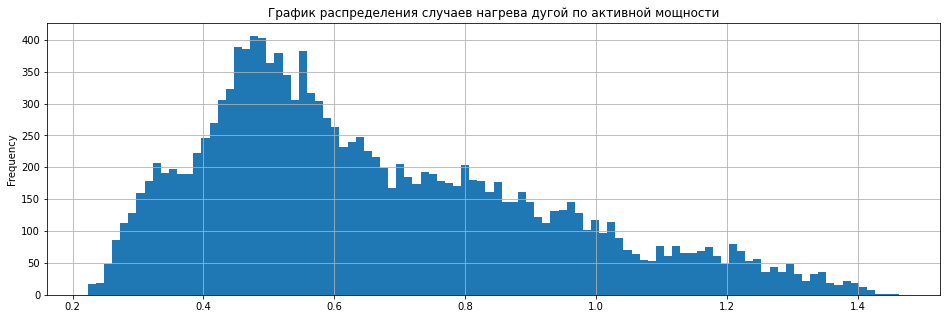

In [ ]:
data_arc['Активная мощность'].plot(kind='hist', bins=100, figsize=(16,5), grid=True,\
        title='График распределения случаев нагрева дугой по активной мощности');

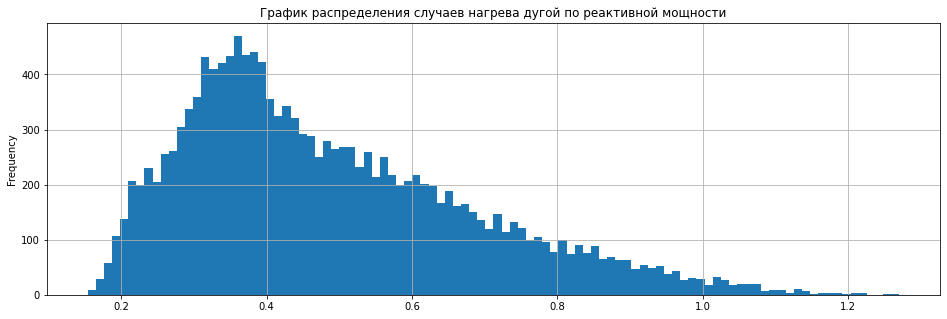

In [ ]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].plot(kind='hist', bins=100, figsize=(16,5), grid=True,\
        title='График распределения случаев нагрева дугой по реактивной мощности');

Итак, показатели активной реактивной мощности несколько смещеы влево, но каких-либо серьеных выбросов мы, в целом, на данных графиках не наблюдаем.

Давайте взглянем на количество аномальных значений реактивной мощности, т.е. количество случаев ее значения меньше либо равное *0*.

In [ ]:
data_arc[data_arc['Реактивная мощность'] <= 0]['Реактивная мощность'].count()

1

#### Изучение данных о подаче сыпучих материалов (объём).

Теперь взглянем на датасет со сведениями об объеме подачи сыпучих материалов.

In [ ]:
show_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В данном датасете содержатся сведения о *3129* случаях подачи сыпучих материалов. По всей видимости, сведения содержащиеся в 15 столбцах `'Bulk'` указывают на объем поданных материалов. Факт наличия 15 разных столбцов, во многих из которых имеются существенное количество пропусков, говорит нам о том, что в разных случаях подавались различные материалы, начиная от всего одного случая (`'Bulk 8'`) до довольно распространенного варианта содержащего *2806* случаев (`'Bulk 14'`). Могло одновременно подаваться несколько типов материалов. По всей вероятности, значение параметра `'key'` в данном датасете уникально, давайте в этом убедимся (должно быть 3129 уникальных ключей).

In [ ]:
len(data_bulk['key'].unique())

3129

Действительно, количество случаев соотвествует количеству уникальных ключей обозначающих партии.

#### Изучение данных о подаче сыпучих материалов (время).

Теперь взглянем на датасет с информацией о времени подачи сыпучих материалов.

In [ ]:
show_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


По всей видимости сведения данного датасета соотвествуют датасету с информацией об объеме подачи сыпучих материалов (в частности одинаковое количество случаев, в первых десяти строках заполнение данными и наличие пропусков идентично). При этом у нас указано только одно время подачи, из которого следует, что, вероятно, подача сыпучих материалов происходит условно одномоментно. В дальнейшем решим, можем ли мы как-то использовать данную информацию. Давайте посмотрим на количество уникальных значений `'key'`, чтобы убедиться, что их, вероятно, 3129, что будет соответствовать количеству случаев.

In [ ]:
len(data_bulk_time['key'].unique())

3129

#### Изучение данных о продувке сплава газом.

Изучим датасет с информацией о продувке сплава стали газом.

In [ ]:
show_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Вероятно, сведения данного датасета  содержат информацию о *3239* случаях подачи газа в сплав, значение в столбце `'Газ 1'` скорее всего сидержат информацию об объеме поданного газа от около *0.008* до почти *78*. Пропусков не имеется. Давайте посмотрим на количество уникальных значений `'key'`, чтобы убедиться, что их, вероятно, 3239, что будет соответствовать количеству случаев.

In [ ]:
len(data_gas['key'].unique())

3239

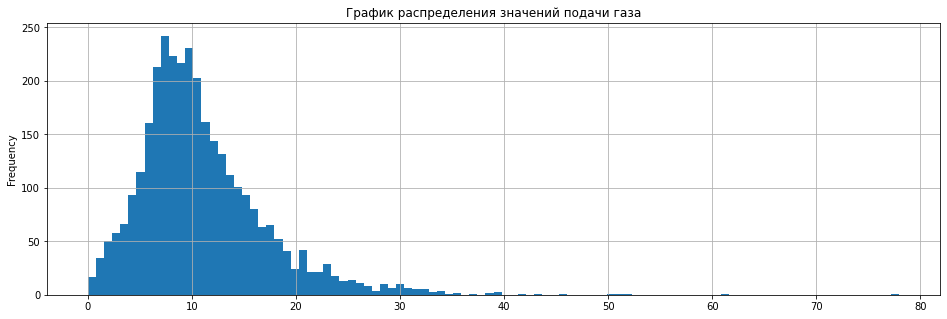

In [ ]:
data_gas['Газ 1'].plot(kind='hist', bins=100, figsize=(16,5), grid=True,\
        title='График распределения значений подачи газа');

Таким образом, мы видим что распределение сильно смещено влево, а справа имеется длинный хвост, который можно полагать выбросами.

#### Изучение данных  о результатах измерения температуры.

Теперь взглянем на информацию о замерах температуры.

In [ ]:
show_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Итак, мы видим 18092 случая замера температуры, также очевидно, что значения параметра `'key'` не являются в данном датасете уникальными, что указывает на то, что в отношении одной и той же партии температура могла замеряться не один раз. При этом значение времени замера ненулевые, но в зачения столбца `'Температура'` заполнены лишь в 14655 случаях, в остальных случаях имеются пропуски, что свидетельствует о том, что в ряде случаев при осуществлении замера температуры либо не срабатывал датчик, либо нам посто не далиэи данные. По всей видимости, испоьзовать сведения с пропусками в данном столбце у нас не получится и нам придется избавиться от этих данных. Давайте взглянем, где у нас имеются такие пропуски.   

In [ ]:
data_temp[data_temp['Температура'].isna()].head(10)

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN
13937,2501,2019-08-10 15:29:00,NaN


Как мы видим, начиная с 13928 случая (учитываем, что индекс первого случая 0) у нас начинаются пропуски в данных о температуре стали. Учитывая, что всего данные о температуре у нас имеются в 14655 случаях, понимаем, что в случаях с 13928 по 18092 в значительной мере отсутствуют данные о температуре (в более чем 4000 случаев содержится лишь окол 700 сведений о температуре).

Также давайте взлянем на количество уникальных ключей, то есть партий, о которых у нас имеются сведения в данном датасете.

In [ ]:
len(data_temp['key'].unique())

3216

Как мы видим, замеры температуры (либо попытки её замера, с учетом наличия пропусков) осуществлялись в отношении 3216 партий.

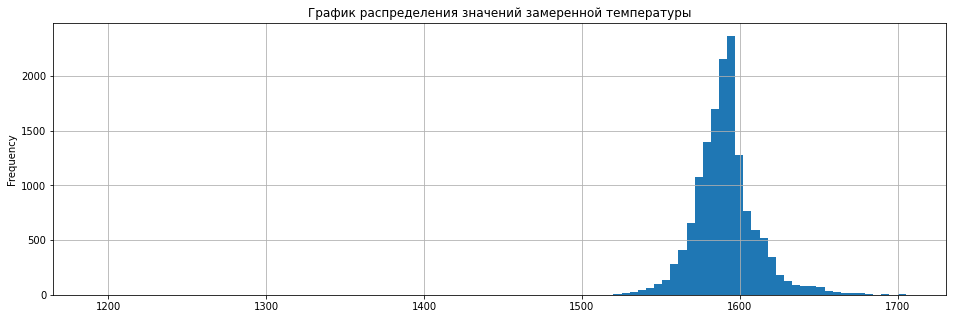

In [ ]:
data_temp['Температура'].plot(kind='hist', bins=100, figsize=(16,5), grid=True,\
        title='График распределения значений замеренной температуры');

График распределения сильно смещен вправо, а слева имеется длинный хвост. Исходя из минимального и максимального значения замеренной температуры, данные хвосты аномалиями и назвать нельзя, но можно рассматривать как выборсы.

#### Изучение данных о проволочных материалах (объём).

Теперь взглянем на сведения о подаче объемов проволочных материалов.

In [ ]:
show_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Данный датасет в целом схож по структуре с датасетом **data_bulk**. В данном датасете содержатся сведения о *3081* случае подачи проволочных материалов. По всей видимости, сведения содержащиеся в 9 столбцах `'Wire'` указывают на объем поданных материалов. Факт наличия 9 разных столбцов, а также то, что во многих из них имеются существенное количество пропусков, говорит нам о том, что в разных случаях подавались различные материалы, начиная от всего одного случая (`'Wire 5'`) до *3055* случаев (`'Wire 1'`). Могло одновременно подаваться несколько типов материалов. По всей вероятности, значение параметра `'key'` в данном датасете уникально, давайте в этом убедимся (должно быть *3081* уникальный ключ).

In [ ]:
len(data_wire['key'].unique())

3081

#### Изучение данных о проволочных материалах (время).

Теперь взглянем на сведения о времени подачи проволочных материалов.

In [ ]:
show_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


По всей видимости сведения данного датасета соотвествуют датасету с информацией об объеме подачи проволочных материалов (в частности одинаковое количество случаев, в первых десяти строках заполнение данными и наличие пропусков идентично). При этом у нас указано только одно время подачи, из которого следует, что, вероятно, подача проволочных материалов происходит условно одномоментно. В дальнейшем решим, можем ли мы как-то использовать данную информацию. Давайте посмотрим на количество уникальных значений `'key'`, чтобы убедиться, что их, вероятно, *3081*, что будет соответствовать количеству случаев.

In [ ]:
len(data_wire_time['key'].unique())

3081

**Выводы по этапу:**

Из данных датасетов следует, что 5 из них содержат ключи, являющиеся уникальными, для двух датасетов данные ключи не уникальны, что говорит о том, что в этим датасетах определенные действия (нагрев дугой, измерение температуры) в отношении одной партии могли повторяться несколько раз. Впоследствии предполагается, что единая таблица для обучения моделей будет собираться на основе данных столбцов `'key'`. Пропуски в датасетах **data_bulk** и **data_wire** полагаю означают, что определенные действия в отношении данной партии не осуществлялись, в связи с чем их можно заменить значением *0*, пропуски в значениях температуры заменить не представляется возможным. Данные о времени в ряде датасетов можно привести к соотвествующему типу. При изучении данных на этом этапе было найдено 1 аномальное значение в столбце `data_arc['Реактивная мощность']`, в ряде датасетов имеются значения, которые могут являться выбросами, но с учетом минимальных и максимальных параметров показателей к аномалиям их отнести нельзя.

### Предобработка данных.

Исходя из изучения имеющихся датасетов, на данном этапе полагаем необходимым изменить тип данных в ряде случаев, по возможности заполнить пропуски, удалить случаи, которые мы не сможем использовать в работе.

Приведем тип данных столбцов датасетов **data_arc** и **data_temp** со временем к типу *datetime64*.

In [ ]:
data_arc[['Начало нагрева дугой', 'Конец нагрева дугой']] = data_arc[['Начало нагрева дугой', 'Конец нагрева дугой']].apply(pd.to_datetime)

In [ ]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

Заполним попуски в датасетах **data_bulk** и **data_wire** начением *0*, полагая, что в данных случаях значение NaN означает, что подача соответствующих типов сыпучих и проволочных материалов не осуществлялась.

In [ ]:
data_bulk = data_bulk.fillna(0)

In [ ]:
data_wire = data_wire.fillna(0)

В сучае же пропусков в датасете **data_temp** мы пропуски каким-либо адекватным значением заполнить не можем, вследствие чего их остается только удалить.

In [ ]:
data_temp = data_temp.dropna()

Также полагаем, что учитывая наличие в датасете **data_arc** сведений о начале и конце нагрева дугой, можно создать столбец со временем такого нагрева, который можно будет использовать в дальнейшем при обучении моделей. Данные столбца сразу же приведем в тип *int* и разделим на *1000000000* (поскольку иначе данные будут приведены в наносекундах, что нам не требуется)

In [ ]:
data_arc['Время нагрева'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('int')/1000000000).astype('int')

Данные о температуре и об объеме сыпучих материалов содержат только целые числа, в связи с чем для уменьшения объема данных их можно привести к типу *int*.

In [ ]:
data_temp['Температура'] = data_temp['Температура'].astype('int')

In [ ]:
for column in data_bulk.columns:
    data_bulk[column] = data_bulk[column].astype('int')

Проверим информацию о результатах проделанных преобразований, убедившись, что всё сделали верно.

In [ ]:
display(data_arc.info())
display(data_bulk.info())
display(data_temp.info())
display(data_wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   Время нагрева         14876 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 697.4 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   Bulk 1   3129 non-null   int64
 2   Bulk 2   3129 non-null   int64
 3   Bulk 3   3129 non-null   int64
 4   Bulk 4   3129 non-null   int64
 5   Bulk 5   3129 non-null   int64
 6   Bulk 6   3129 non-null   int64
 7   Bulk 7   3129 non-null   int64
 8   Bulk 8   3129 non-null   int64
 9   Bulk 9   3129 non-null   int64
 10  Bulk 10  3129 non-null   int64
 11  Bulk 11  3129 non-null   int64
 12  Bulk 12  3129 non-null   int64
 13  Bulk 13  3129 non-null   int64
 14  Bulk 14  3129 non-null   int64
 15  Bulk 15  3129 non-null   int64
dtypes: int64(16)
memory usage: 391.2 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   Время замера  14665 non-null  datetime64[ns]
 2   Температура   14665 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 458.3 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

In [ ]:
len(data_temp['key'].unique())

3216

Данные датасета **data_gas** нас устраивают. Как можно будет применить данные датасетов **data_bulk_time** и **data_wire_time** для обучения моделей пока не ясно, поэтому их пока не трогаем.

Приступим ко второй части проекта. Подготовим данные к объединению в общую таблицу, на которой будем впоследствии обучать модели. Начнем с `data_temp`, поскольку там содержится также и целевой признак. Для начала найдем "плохие ключи", то есть те случаи, когда после последнего замера происходит еще нагревание дугой (такие факты считаем аномальными, поскольку последняя температура не соотвествует своему наименованию), а также случаи, когда имелся всего лишь один замер температуры (эти данные нам не подходят, так как нет достаточных данных). Сведения о таких "плохих ключах" сохраним в переменную **bad_keys**.

In [ ]:
defect_keys = []
for key in list(data_temp['key'].unique()):
    if (data_temp[data_temp['key'] == key]['Время замера'].max() < \
        data_arc[data_arc['key'] == key]['Конец нагрева дугой'].max()) \
    or (data_temp[data_temp['key'] == key]['Время замера'].max() == \
        data_temp[data_temp['key'] == key]['Время замера'].min()):
        defect_keys.append(key)
len(defect_keys)

741

Таким образом, у нас имеется 741 случай, который не подходит для обучения моделей. Удалим их из датасета.

In [ ]:
data_temp = data_temp.query('key not in @defect_keys')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   Время замера  13924 non-null  datetime64[ns]
 2   Температура   13924 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 435.1 KB


Теперь поработатем с датасетом следующим образом. Поскольку у нас имеется несколько замеров температуры одной партии, вычленим время первого и последнего замера температуры в партиии, ключи переведем в индекс. Предварительно наименования колонок приведем в англоязычный формат.

In [ ]:
data_temp.columns = ['key', 'time','temperature']

In [ ]:
measurement_time = pd.pivot_table(data_temp,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
measurement_time.head()

,amax,amin
key,,
1,2019-05-03 11:30:38,2019-05-03 11:02:04
2,2019-05-03 11:55:09,2019-05-03 11:34:04
3,2019-05-03 12:35:57,2019-05-03 12:06:44
4,2019-05-03 12:59:47,2019-05-03 12:39:27
5,2019-05-03 13:36:39,2019-05-03 13:11:03


Поскольку само по себе время замера температуры нам ничего особо не скажет, для нас куда более интересным представляется время между первым и последним замером. Создаем признак времени от начала (время первого замера температуры) до конца (время последнего замера температуры) работы с партией.

In [ ]:
measurement_time['total_time'] = ((measurement_time['amax'] - measurement_time['amin']).astype('int')/1000000000).astype('int')

Теперь вычлениым полученную в ходе первого и последнего замера собственно саму температуру, также переведя ключ в индекс (поскольку на основе этих индексов и будем объединять впоследствии данные разных датасетов).

Сначала создадим списки, содержащие время первого замера и последнего замера температуры.

In [ ]:
first_time = list(measurement_time['amin'])
last_time = list(measurement_time['amax'])

После этого методом query из датасета **date_temp** отберем температуру, которая была получена в ходе первого замера. При этом ключи новой таблицы передадим в индекс.

In [ ]:
data_first_temp = data_temp.query('time in @first_time')
data_first_temp = data_first_temp.set_index('key')

То же самое сделаем с последней температурой партии.

In [ ]:
data_last_temp = data_temp.query('time in @last_time')
data_last_temp = data_last_temp.set_index('key')

Переименуем в таблице с первой температурой столбец температуры.

In [ ]:
data_first_temp.columns = ['time', 'first_temp']


Создадим копию датафрейма с первой температурой с новым названием и присоедним столбец с последней температурой.

In [ ]:
data_temperature = data_first_temp.copy()
data_temperature['last_temp'] = data_last_temp['temperature']

Более нам не потребуется в данном датафрейме столбец времени, удалим его.

In [ ]:
data_temperature = data_temperature.drop('time', axis=1)
data_temperature.head()

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602


Теперь поработаем с датасетом **data_arc**, поскольку нам также не так уж интересны непосредственно время и затраты энергии на каждый конкретный нагрев дугой, создадим табицу pivot со сведениями отдельно по каждой партии суммами активной мощности, реактивной мощности и времени осуществления нагрева. В индексы также передадим ключи партий.  

In [ ]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power', 'heating_time'] # Даем англоязычные названия
data_arc = data_arc.query('reactive_power > 0') # Исключаем аномальое отрицательное значение
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power', 'heating_time'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum,
                                     'heating_time': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_heating_time', 'sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_heating_time,sum_reactive_power
key,,,
1,3.036730,1098,2.142821
2,2.139408,811,1.453357
3,4.063641,655,2.937457
4,2.706489,741,2.056992
5,2.252950,869,1.687991


Пока поверялась первая часть проекта, я все-таки вроде придумал, как можно использовать датасеты **data_bulk_time** и **data_wire_time**. Сначала показалось, что получение временных признаков (месяц, день, час) какой-либо значимой информации не даст, если и есть разница температур днем и ночью в цехе, в котором находится ковш, то она, думаю, не настолько существенная, чтобы оказать значительное влияние. Однако, возникла мысль, что возможно может играть время добавления сыпучих и проволочных мероприятий относительно времени начального и конечного замера температуры, хотя достоверно пока не знаю. Ну попробуем использовать эти данные так.

Поэтому приведем данные о времени этих датасетов к *datetime64* (при этом исключим из данного процесса столбец `'key'`), после чего заменим пропуски значением *0*.

In [ ]:
for column in data_bulk_time.columns:
    if column[0] != 'B':
        continue
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])

In [ ]:
data_bulk_time = data_bulk_time.fillna(0)

In [ ]:
for column in data_wire_time.columns:
    if column[0] != 'W':
        continue
    data_wire_time[column] = pd.to_datetime(data_wire_time[column])

In [ ]:
data_wire_time = data_wire_time.fillna(0)

Теперь переведем ключи партий в индексы оставшихся датасетов (**data_bulk, data_gas, data_wire, data_bulk_time, data_wire_time**).

In [ ]:
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')
data_bulk_time = data_bulk_time.set_index('key')
data_wire_time = data_wire_time.set_index('key')

Для последующей удобной работы также переименуем названия столбцов с русскоязычного варианта в английский.

In [ ]:
data_bulk_time.columns = [f'bulk_time_{x}' for x in range(1, 16)]
data_wire_time.columns = [f'wire_time_{x}' for x in range(1, 10)]
data_gas.columns = ['gas']

Теперь создадим единую таблицу, в которую передадим интересующие нас данные всех имеющихся датасетов.

In [ ]:
general_data = pd.concat([data_temperature, measurement_time, data_arc_sum, data_bulk, data_bulk_time, data_gas, data_wire, data_wire_time], axis=1, sort=False)

In [ ]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_temp          2475 non-null   float64       
 1   last_temp           2475 non-null   float64       
 2   amax                2475 non-null   datetime64[ns]
 3   amin                2475 non-null   datetime64[ns]
 4   total_time          2475 non-null   float64       
 5   sum_active_power    3214 non-null   float64       
 6   sum_heating_time    3214 non-null   float64       
 7   sum_reactive_power  3214 non-null   float64       
 8   Bulk 1              3129 non-null   float64       
 9   Bulk 2              3129 non-null   float64       
 10  Bulk 3              3129 non-null   float64       
 11  Bulk 4              3129 non-null   float64       
 12  Bulk 5              3129 non-null   float64       
 13  Bulk 6              3129 non-null   float64     

У нас получилась таблица с 57 признаками. Однако, вследствие удаления аномалий и непригодных данных в ряде датасетов, у нас имеется некоторое количество пропусков в различных столбцах. Давайте посмотрим.

In [ ]:
general_data.isna().sum()

first_temp            766
last_temp             766
amax                  766
amin                  766
total_time            766
sum_active_power       27
sum_heating_time       27
sum_reactive_power     27
Bulk 1                112
Bulk 2                112
Bulk 3                112
Bulk 4                112
Bulk 5                112
Bulk 6                112
Bulk 7                112
Bulk 8                112
Bulk 9                112
Bulk 10               112
Bulk 11               112
Bulk 12               112
Bulk 13               112
Bulk 14               112
Bulk 15               112
bulk_time_1           112
bulk_time_2           112
bulk_time_3           112
bulk_time_4           112
bulk_time_5           112
bulk_time_6           112
bulk_time_7           112
bulk_time_8           112
bulk_time_9           112
bulk_time_10          112
bulk_time_11          112
bulk_time_12          112
bulk_time_13          112
bulk_time_14          112
bulk_time_15          112
gas         

Поскольку интерес заказчика представляет работа только с полными данными, остается только удалить все случаи с попусками в ряде данных.

In [ ]:
general_data = general_data.dropna()
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_temp          2329 non-null   float64       
 1   last_temp           2329 non-null   float64       
 2   amax                2329 non-null   datetime64[ns]
 3   amin                2329 non-null   datetime64[ns]
 4   total_time          2329 non-null   float64       
 5   sum_active_power    2329 non-null   float64       
 6   sum_heating_time    2329 non-null   float64       
 7   sum_reactive_power  2329 non-null   float64       
 8   Bulk 1              2329 non-null   float64       
 9   Bulk 2              2329 non-null   float64       
 10  Bulk 3              2329 non-null   float64       
 11  Bulk 4              2329 non-null   float64       
 12  Bulk 5              2329 non-null   float64       
 13  Bulk 6              2329 non-null   float64     

Итак, у нас получилась таблица с 57 признаками, в которой имеются полные сведения о 2329 партиях. Учитывая, что изначально сведения датасетов содержали информацию о 3241 партии (максимальный имевшийся номер `'key'`), в результате обработки данных нами было отбраковано менее 30% партий, информация о которых была не полна и не могла быть использована в работе.  

Теперь продолжим работу с данными времени осуществления добавки сыпучих и проволочных материалов. Поскольку само по себе время его осуществления нам ничего не говорит. Однако можно использовать сведения о количестве времени, прошедшего с первого замера температуры до времени добавки таких материалов, а также соотнести его общим временем работы с партией, таким образом, мы получим сведения о так сказать "долевом времени" относительно общего времени, то есть на какой момент в долевом рассмотрении времени работы с партией пришлось добавление тех или иных материалов. Для этого обработаем датасеты **data_bulk_time** и **data_wire_time** следующим образом, создадим функцию, которая в случае, если значение не равно *0* (то есть не имелось добавления материалов) от времени добавления материалов вычитала время первого замера температуры (воспринимаем как время начала работы с партией), после чего переводила это время в секунды и делила на ранее нами найденное общее время работы с партией. После этого используем данную функцию через **apply**.     

In [ ]:
def getting_time(row):
    for x in range(1, 16):
        if row[f'bulk_time_{x}'] == 0:
            continue
        else:
            row[f'bulk_time_{x}'] = (row[f'bulk_time_{x}'] - row['amin']) / pd.Timedelta(seconds=1) / row['total_time']
    for y in range(1, 10):
        if row[f'wire_time_{y}'] == 0:
            continue
        else:
            row[f'wire_time_{y}'] = (row[f'wire_time_{y}'] - row['amin']) / pd.Timedelta(seconds=1) / row['total_time']
    return row

In [ ]:
general_data = general_data.apply(getting_time, axis=1)

Теперь взглянем на информацию о полученной таблице.

In [ ]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_temp          2329 non-null   float64       
 1   last_temp           2329 non-null   float64       
 2   amax                2329 non-null   datetime64[ns]
 3   amin                2329 non-null   datetime64[ns]
 4   total_time          2329 non-null   float64       
 5   sum_active_power    2329 non-null   float64       
 6   sum_heating_time    2329 non-null   float64       
 7   sum_reactive_power  2329 non-null   float64       
 8   Bulk 1              2329 non-null   float64       
 9   Bulk 2              2329 non-null   float64       
 10  Bulk 3              2329 non-null   float64       
 11  Bulk 4              2329 non-null   float64       
 12  Bulk 5              2329 non-null   float64       
 13  Bulk 6              2329 non-null   float64     

Также хочется взглянуть на саму таблицу, но предварительно надо убрать ограничение на количество доступных к просмотру столбцов.

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
general_data.head()

,first_temp,last_temp,amax,amin,total_time,sum_active_power,sum_heating_time,sum_reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,2019-05-03 11:30:38,2019-05-03 11:02:04,1714.0,3.036730,1098.0,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,0.0,0.935823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.785881,0.0,0.446908,0.302800,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148775,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,2019-05-03 11:55:09,2019-05-03 11:34:04,1265.0,2.139408,811.0,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,0.0,0.131225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.921739,0.0,0.690119,0.501976,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131225,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2019-05-03 12:35:57,2019-05-03 12:06:44,1753.0,4.063641,655.0,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,0.0,0.887051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701084,0.0,0.488876,0.326298,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172276,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,2019-05-03 12:59:47,2019-05-03 12:39:27,1220.0,2.706489,741.0,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,0.0,0.192623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.912295,0.0,0.577049,0.351639,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192623,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,2019-05-03 13:36:39,2019-05-03 13:11:03,1536.0,2.252950,869.0,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,0.0,0.770833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.770833,0.0,0.904297,0.770833,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378255,0.176432,0.0,0.0,0,0.0,0.0,0.0,0.0


Теперь данные о времени первого и последнего замера температуры нам не нужны, можем удалить ненужные больше столбцы **amax** и **amin** (всю необходимую информацию от них мы уже получили).

In [ ]:
general_data = general_data.drop(['amax', 'amin'], axis=1)

Теперь решим вопрос с активной и реактивной мощностью. С одной стороны, энергия затрачивается на оба случая, в то же время наиболее интересна с функциональной точки зрения активная мощность. Чтобы решить данный вопрос, давайте взглянем на корреляцию этих двух признаков.

In [ ]:
general_data['sum_active_power'].corr(general_data['sum_reactive_power'])

0.9924244806892585

Их корреляция практически прямая и линейная (более 0,99), что позволяет фактически убрать одну из них. В то же время можно пойти путем создания признака суммы активной и реактивной мощности, так как они находятся практически в прямой линейной зависимости друг от друга и будут лишь способстовать эффекту мультиколлинеарности, что нам крайне не желательно. Создадим новый столбец с суммами активной и реактивной мощности.

In [ ]:
general_data['sum_power'] = general_data['sum_active_power'] + general_data['sum_reactive_power']

Теперь больше собственно столбцы активной и реактивной мощности нам более не нужны.

In [ ]:
general_data = general_data.drop(['sum_active_power', 'sum_reactive_power'], axis=1)
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   first_temp        2329 non-null   float64
 1   last_temp         2329 non-null   float64
 2   total_time        2329 non-null   float64
 3   sum_heating_time  2329 non-null   float64
 4   Bulk 1            2329 non-null   float64
 5   Bulk 2            2329 non-null   float64
 6   Bulk 3            2329 non-null   float64
 7   Bulk 4            2329 non-null   float64
 8   Bulk 5            2329 non-null   float64
 9   Bulk 6            2329 non-null   float64
 10  Bulk 7            2329 non-null   float64
 11  Bulk 8            2329 non-null   float64
 12  Bulk 9            2329 non-null   float64
 13  Bulk 10           2329 non-null   float64
 14  Bulk 11           2329 non-null   float64
 15  Bulk 12           2329 non-null   float64
 16  Bulk 13           2329 non-null   float64


Теперь проведем анализ данных, построим графики распределения, плотности распределения и boxplot каждого признака. Сначала создадим функцию, которая будет составлять нам данные графики.

In [ ]:
def draw_charts(sign):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.distplot(general_data[sign])
    plt.title('Распределение частоты и плотности')
    plt.show();
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(general_data[sign])
    plt.title('Диаграмма размаха')
    plt.show();

Теперь взглянем на графики по последней температуре стали.

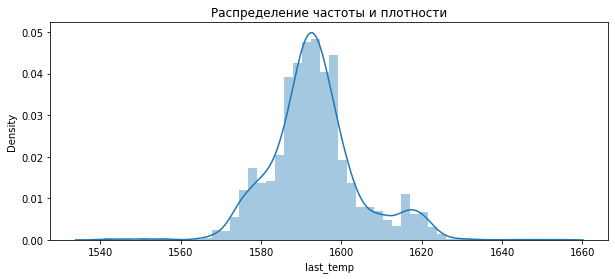

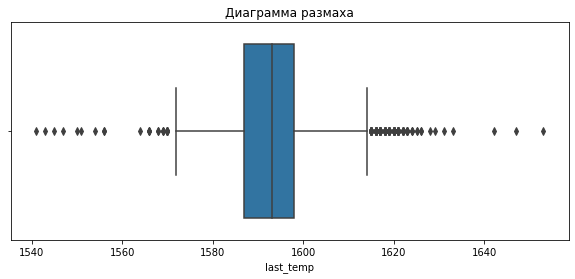

In [ ]:
draw_charts('last_temp')

Наибольшее количество случаев указывает на последнюю температуру от 1565 до 1625. Имеются и ряд выбросов, но они не являются аномалиями. Взглянем на графики по первой замеренной температуре.

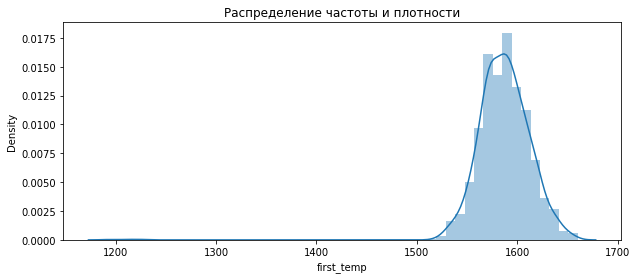

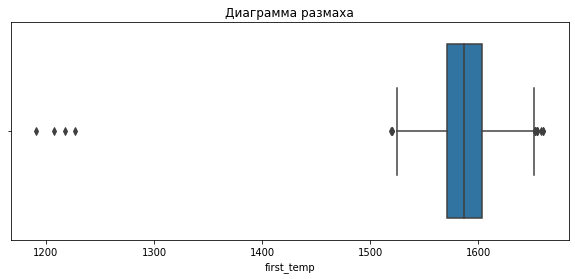

In [ ]:
draw_charts('first_temp')

Наибольшее количество случаев указывает на последнюю температуру от 1530 до 1650. Имеются и ряд выбросов, в том числе часть нахдится в районе 1200, но они не являются аномалиями. Взглянем на графики по суммарой затраченной мощности.

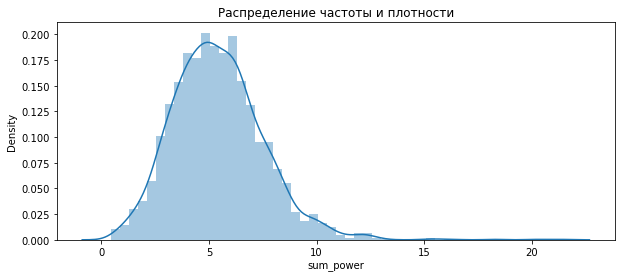

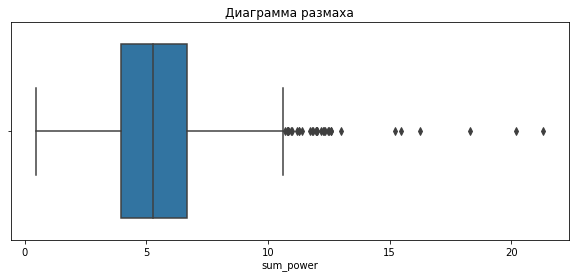

In [ ]:
draw_charts('sum_power')

Наибольшее количество случаев указывает на затраты мощности от 1 до 10. Имеются и ряд выбросов, но они не являются аномалиями. Взглянем на графики по затраченному времени на партию.

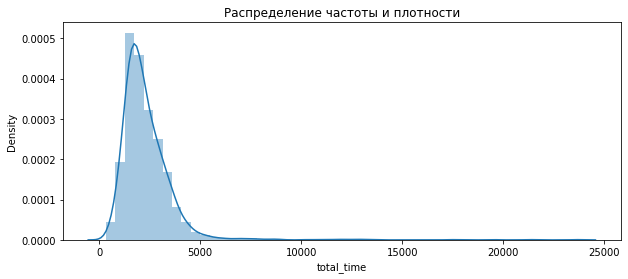

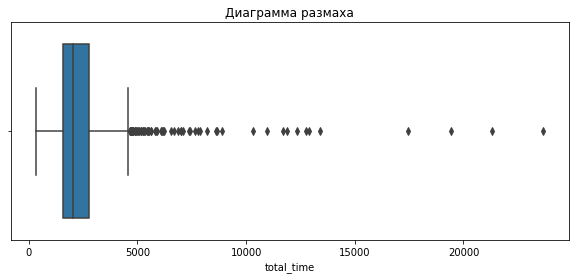

In [ ]:
draw_charts('total_time')

Наибольшее количество случаев указывает на то, что на работу с партией обычно времени уходит менее 5000. Имеются и ряд выбросов, но их также нельзя назвать аномалиями. Взглянем на графики по времени, затраченному на нагрев дугой.

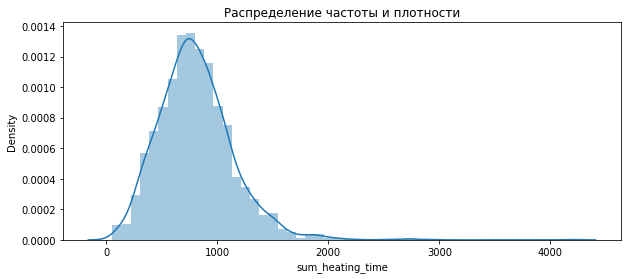

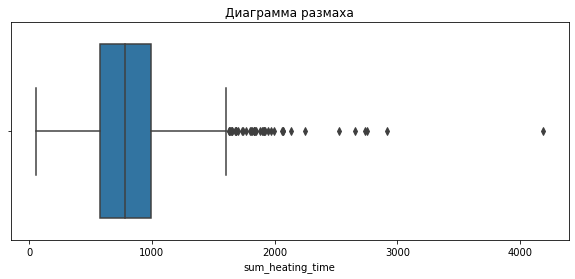

In [ ]:
draw_charts('sum_heating_time')

Наибольшее количество случаев указывает, что на нагрев дугой обычно времени уходит менее 1500. Имеются и ряд выбросов, но их также нельзя назвать аномалиями. Взглянем на графики по прменению газа.

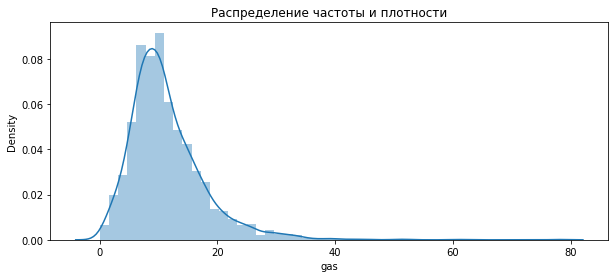

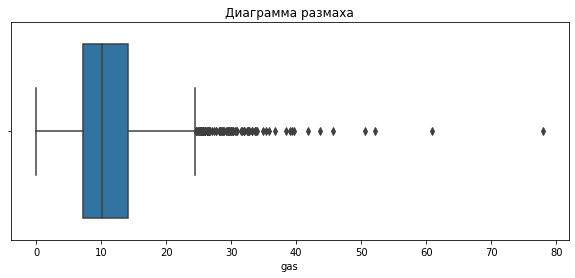

In [ ]:
draw_charts('gas')

Наибольшее количество случаев указывает на применение газа от 0 до 25. Имеются и ряд выбросов, но они не являются аномалиями. Взглянем на графики по применению сыпучих материалов, данные признаки предлагаю оценить в их комплексе.

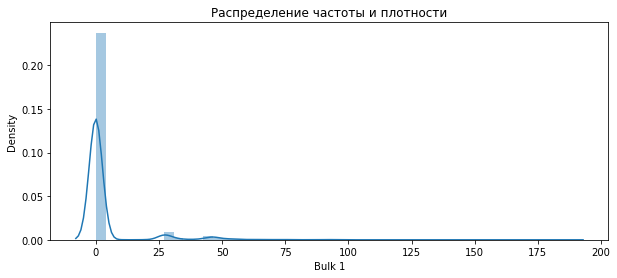

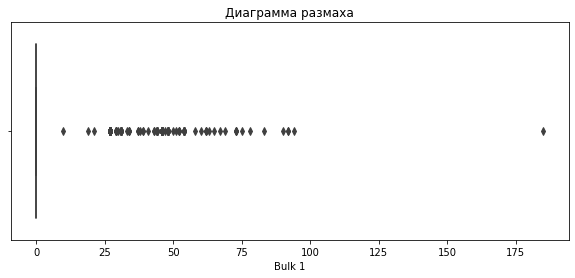

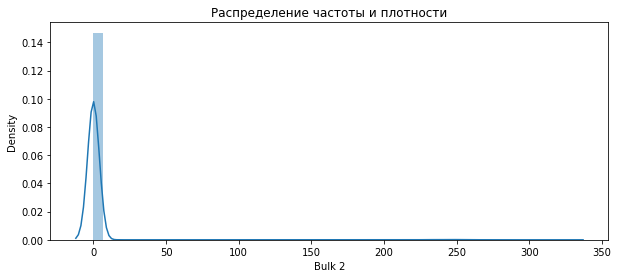

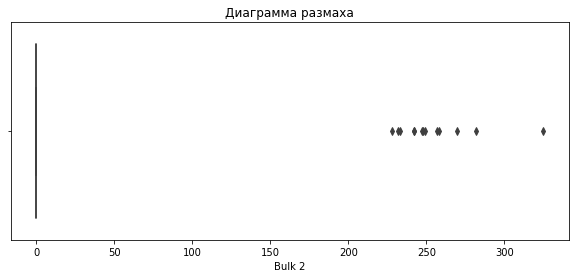

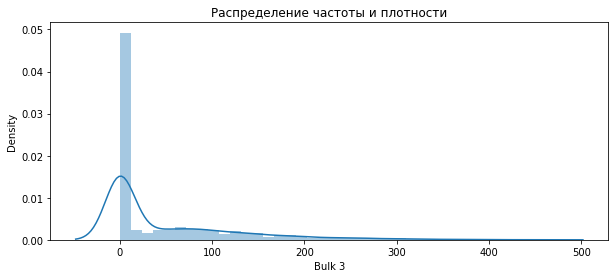

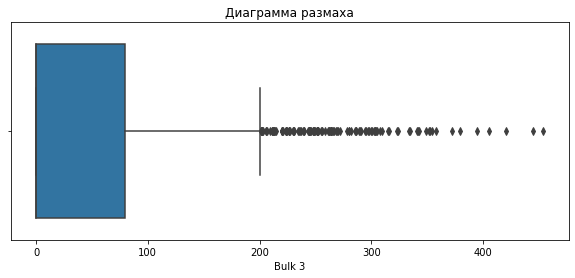

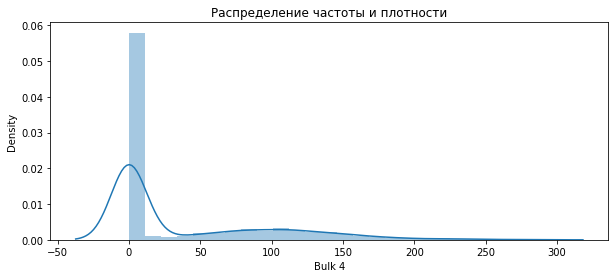

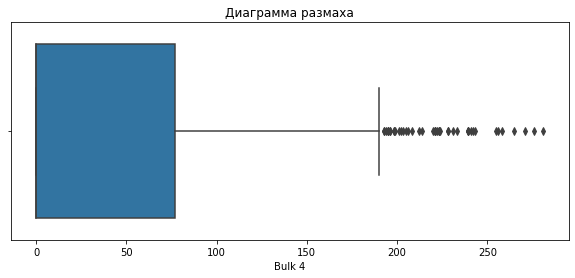

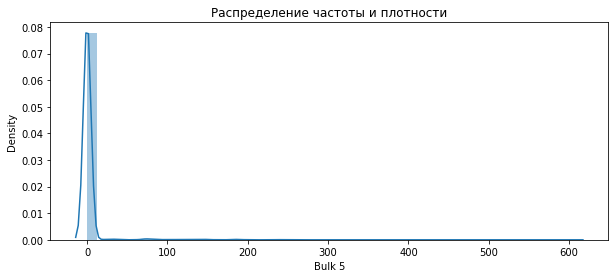

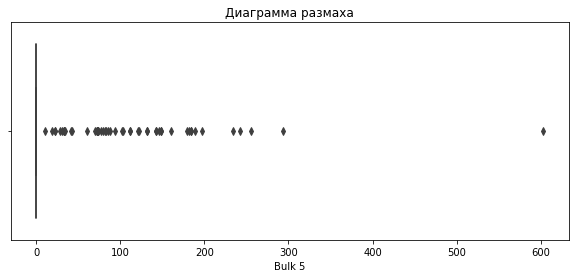

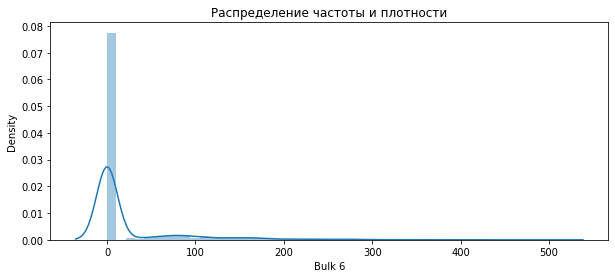

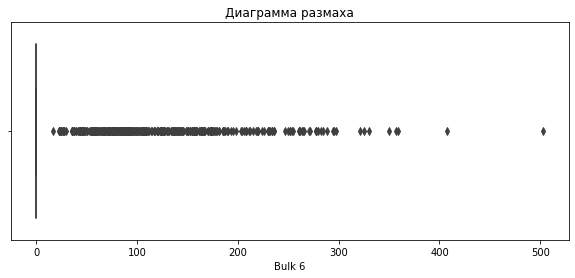

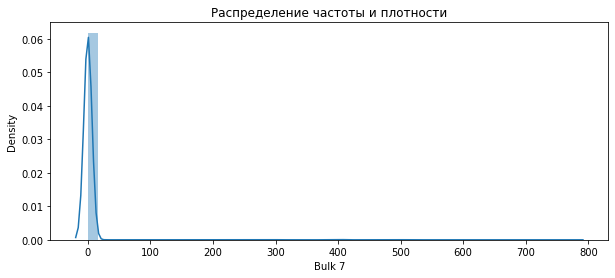

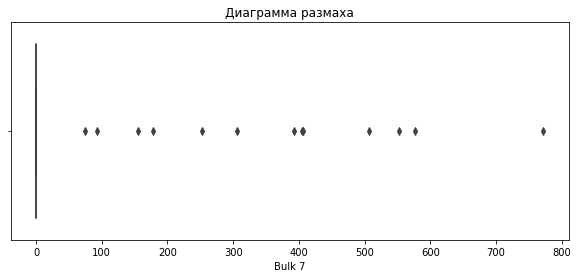

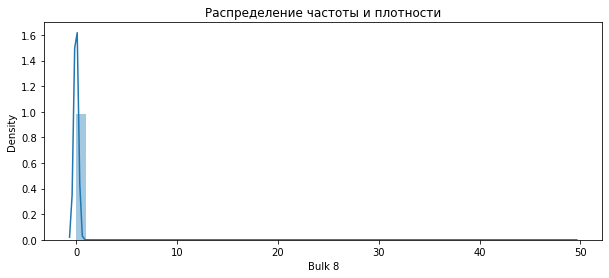

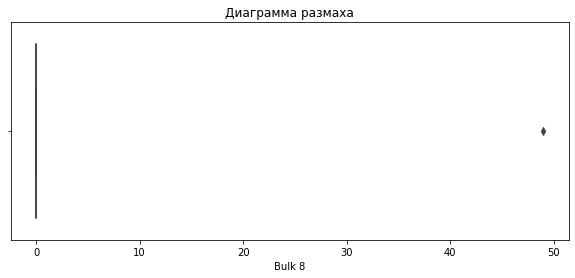

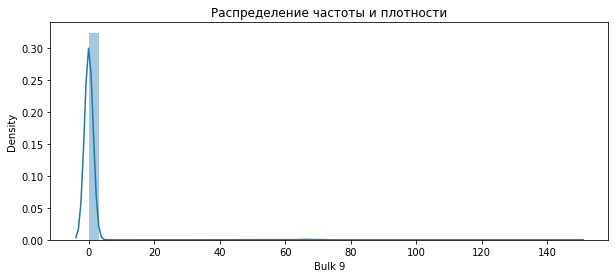

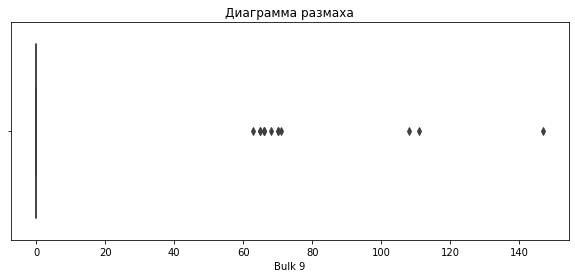

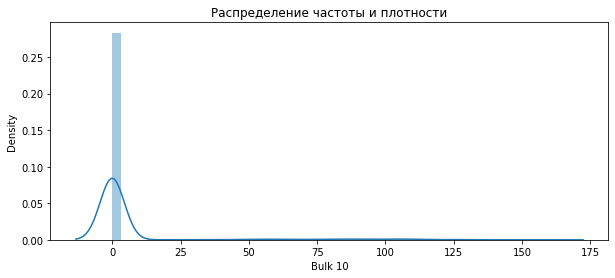

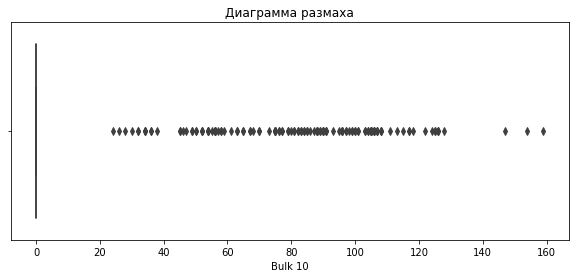

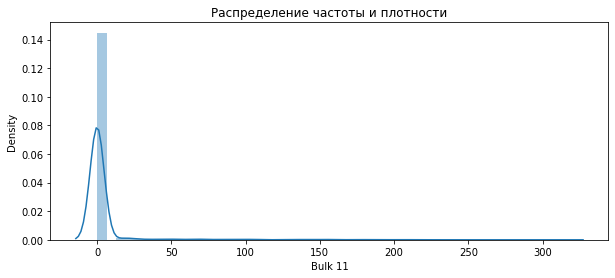

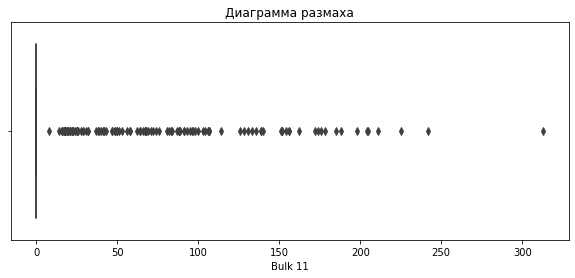

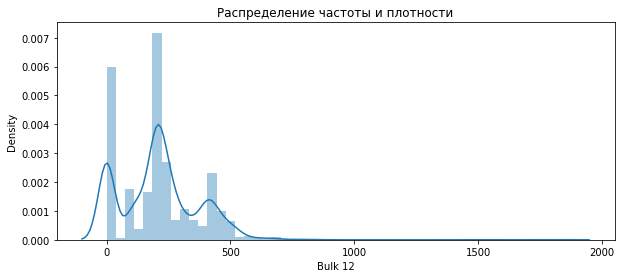

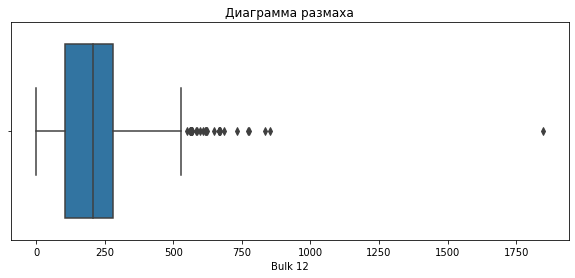

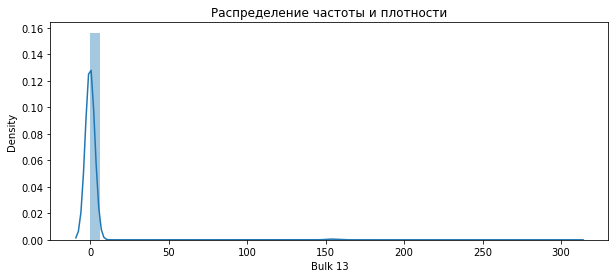

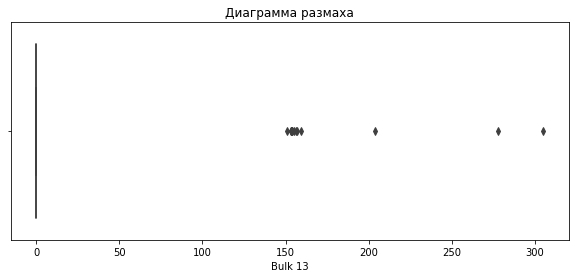

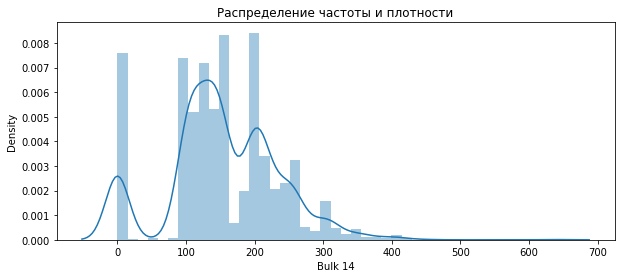

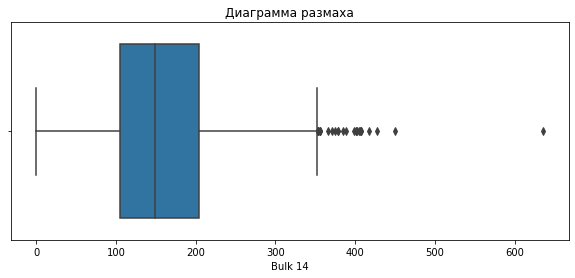

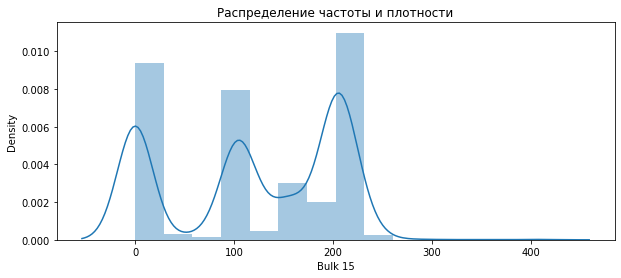

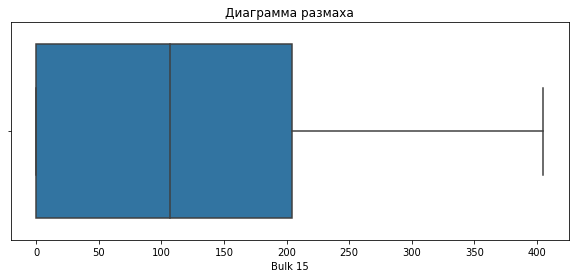

In [ ]:
for column in general_data.columns:
    if column[0] != 'B':
        continue
    draw_charts(column)

Также посмотрим и на показатель времени применения данных материалов.

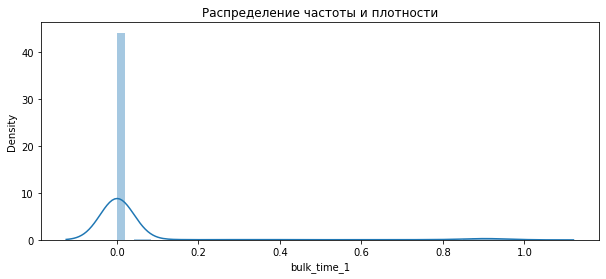

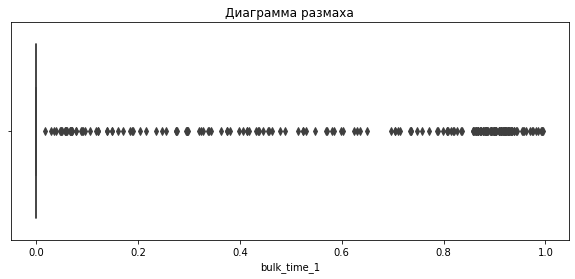

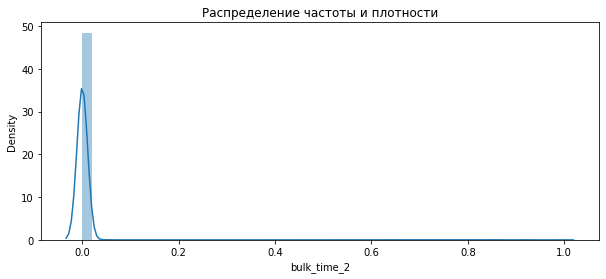

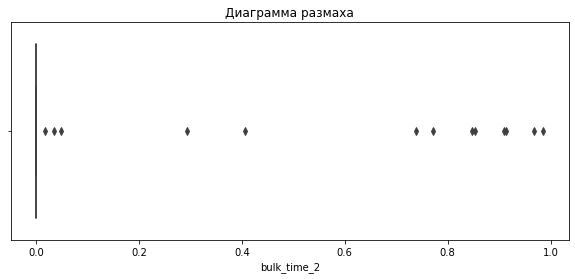

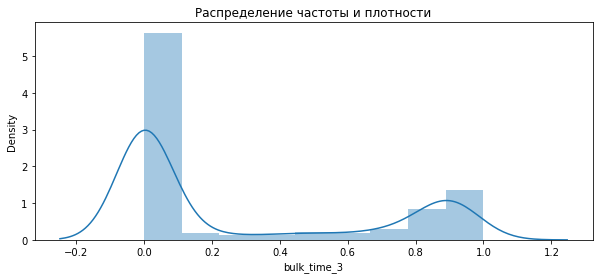

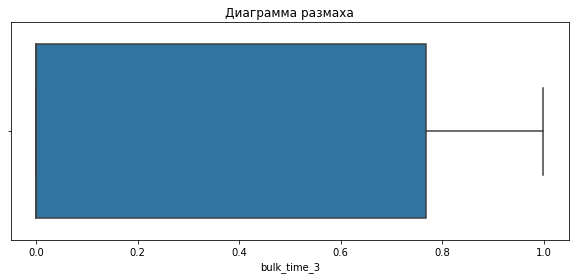

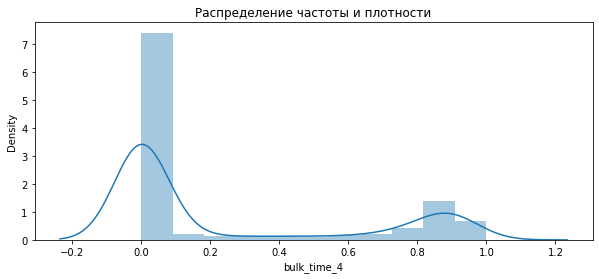

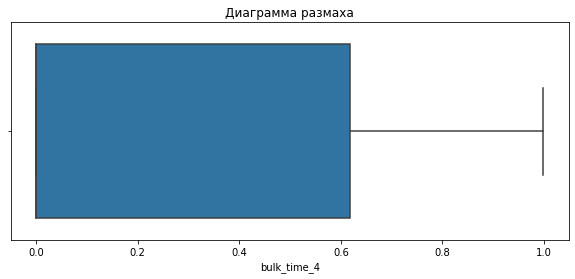

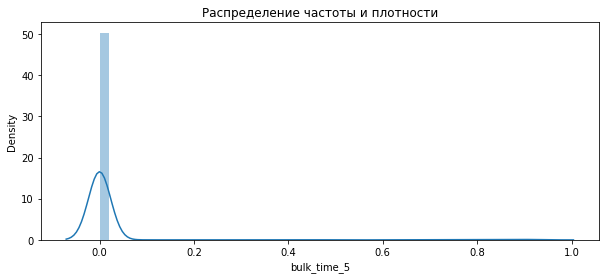

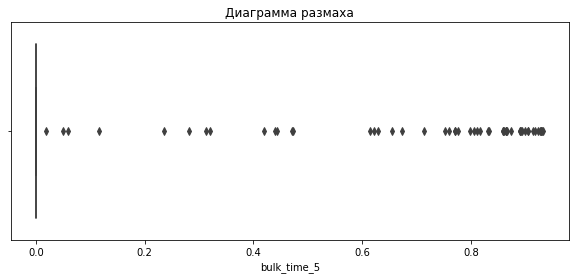

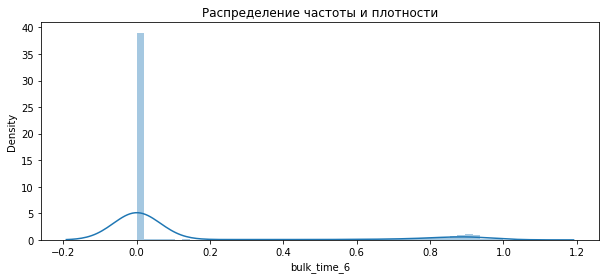

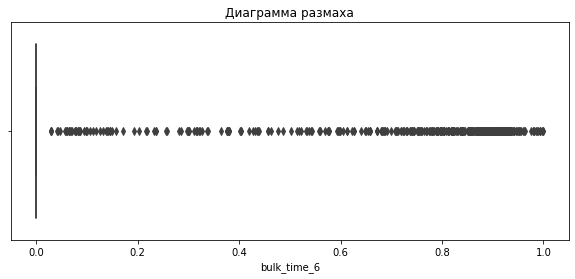

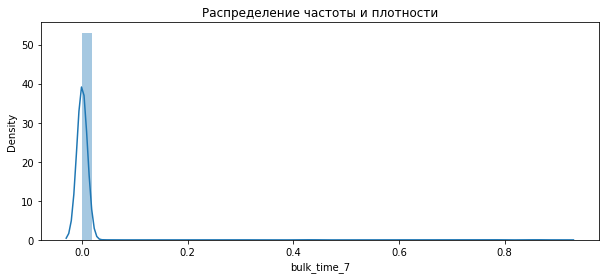

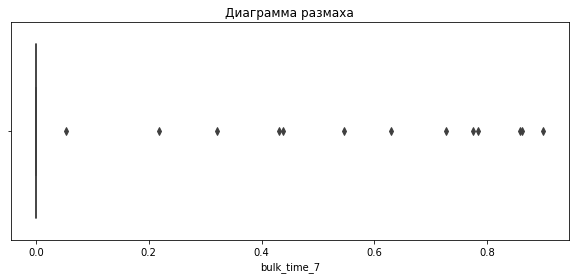

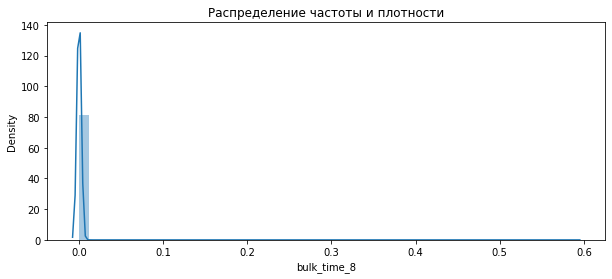

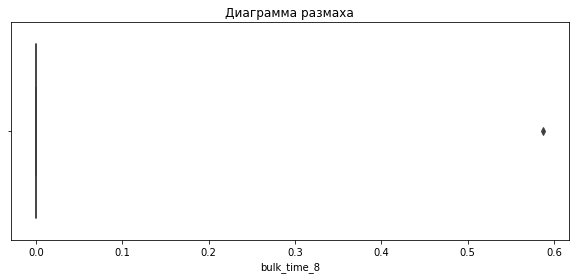

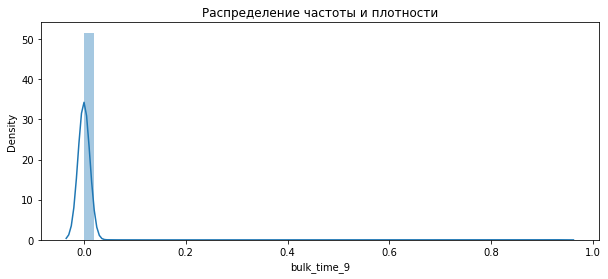

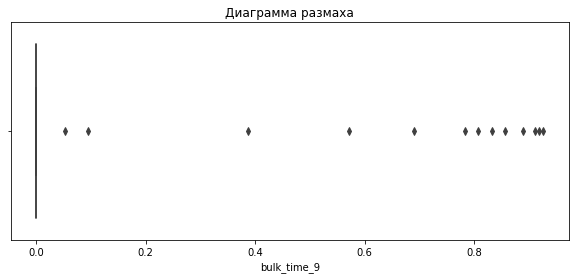

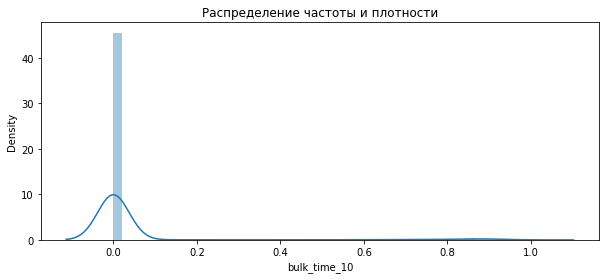

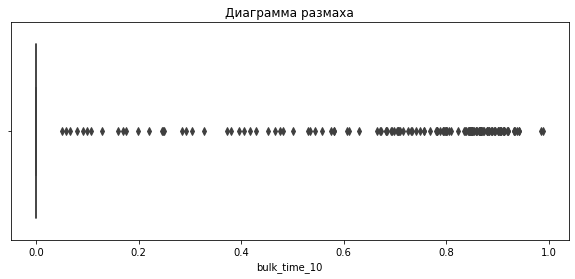

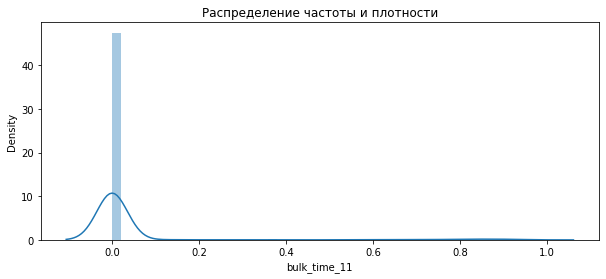

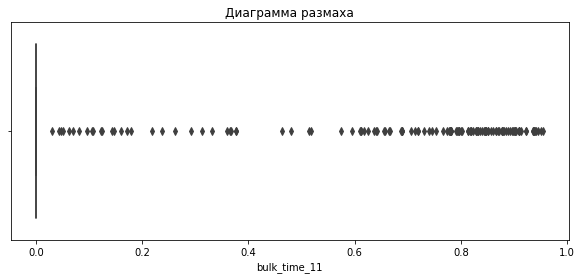

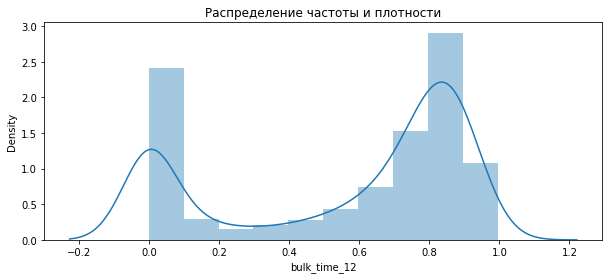

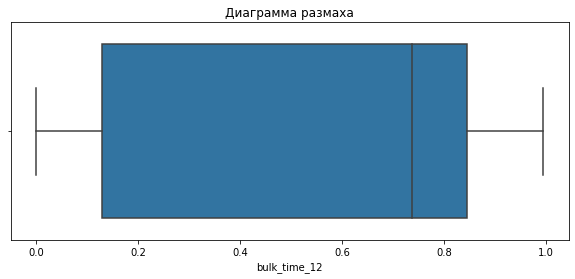

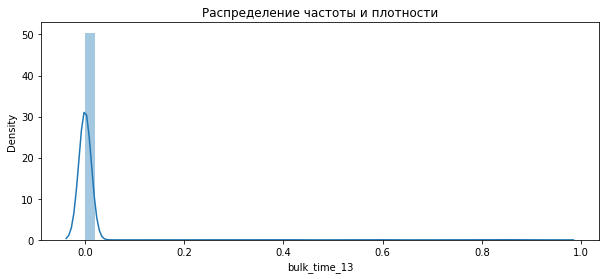

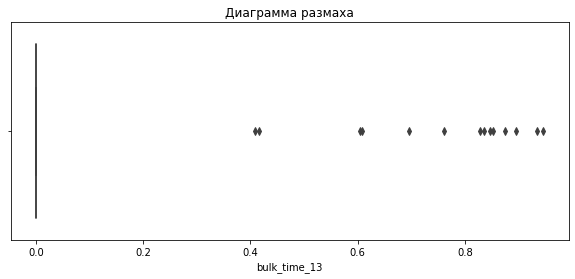

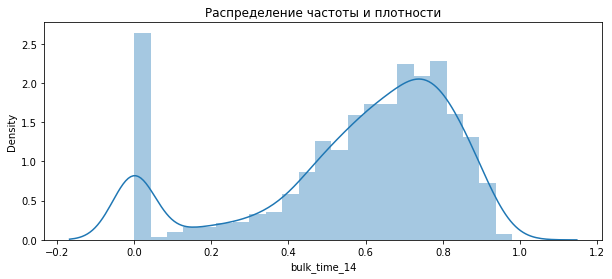

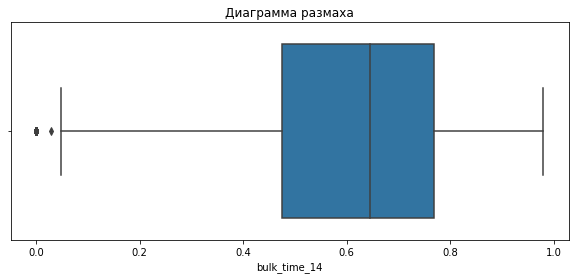

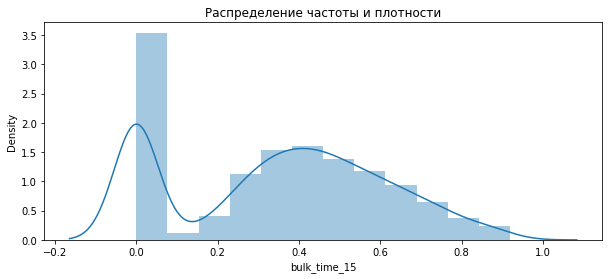

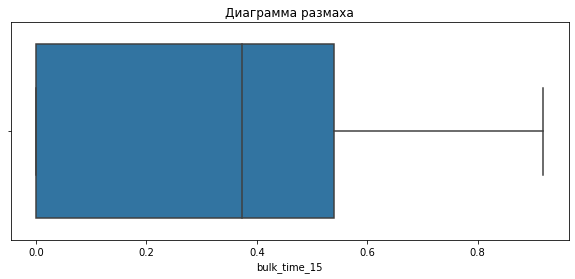

In [ ]:
for column in general_data.columns:
    if column[0] != 'b':
        continue
    draw_charts(column)

Как мы видим, существенное значение, вероятно будут иметь признаки подачи супучих материалов (как по объему так и по времени, так как они в целом имеют сходное значеие по причине их существенной корреляции друг с другом) под номерами 3, 4, 12, 14, 15, которые, разумеется, смещены влево ввиду их использования не всегда и соответствено наличия в этих признаков условных показателей *0*. В то же время остальные признаки применялись очень нечасто, вследствие графики показывают основное нахожение их значений в районе *0*. По всей видимости, такие признаки можно было бы и удалить из обучающей выборки как выбросы, но в то же время мы не знаем, как в действительности они могли бы влиять на целевой показатель, в связи с чем имеется желание пока их оставить и вернуться к данному вопросу лишь в случае, если задача не будет решаться.

Взглянем на графики по применению проволочных материалов, данные признаки предлагаю оценить в их комплексе.

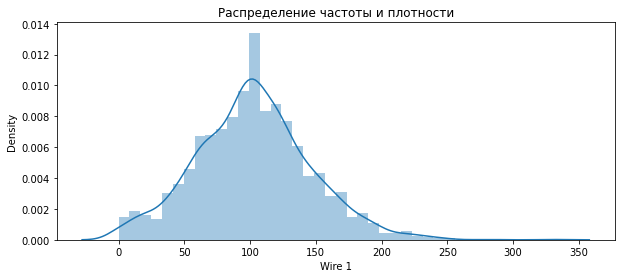

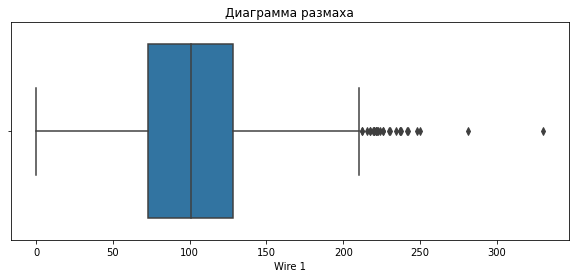

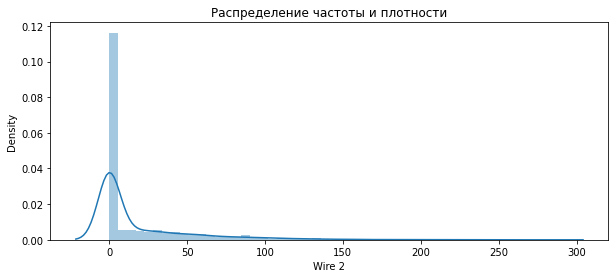

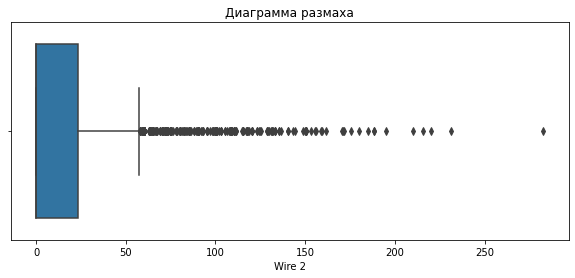

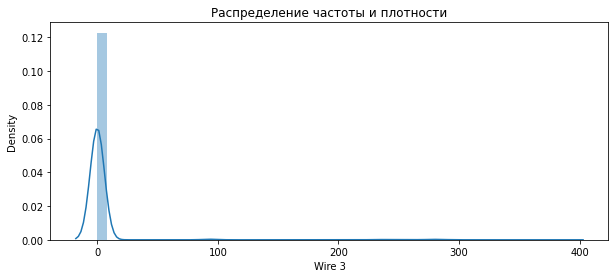

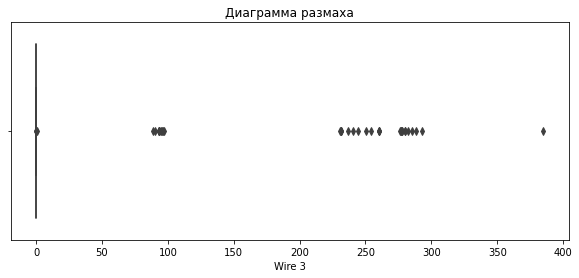

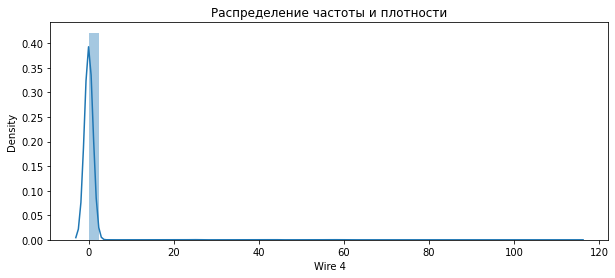

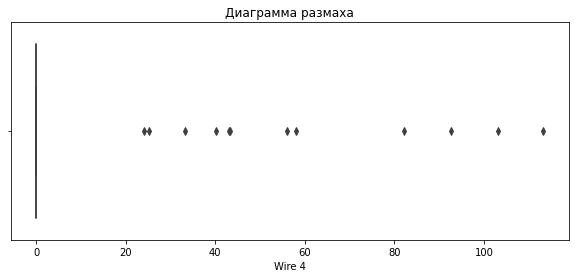

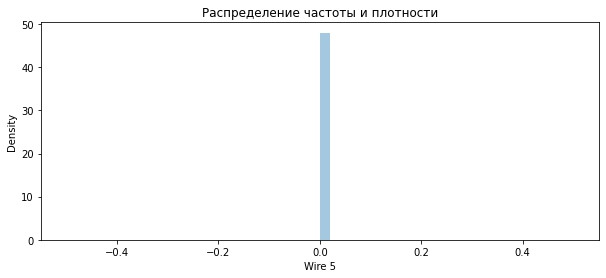

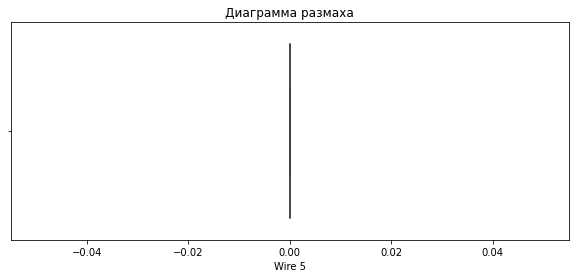

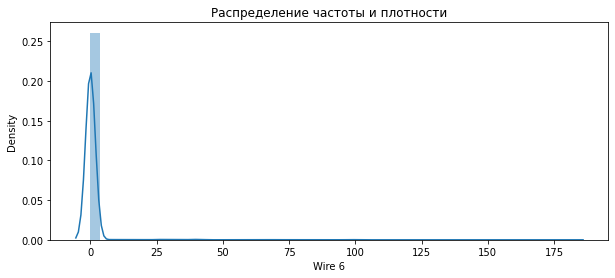

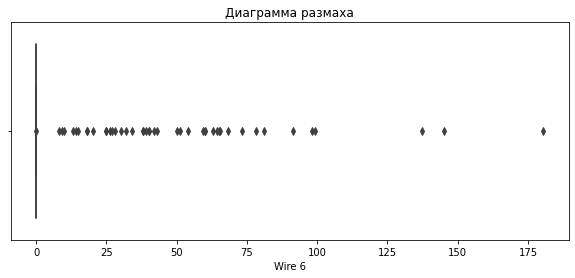

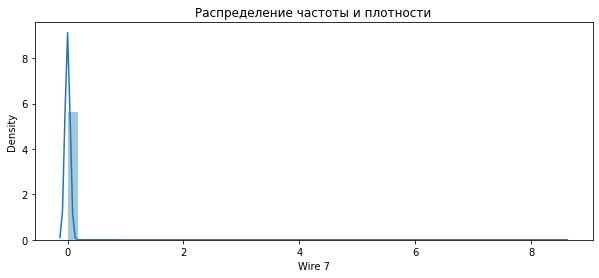

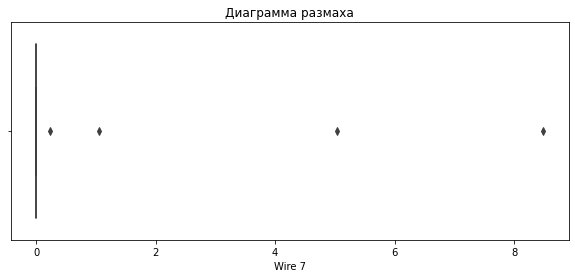

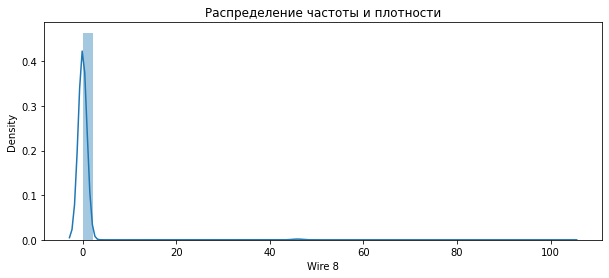

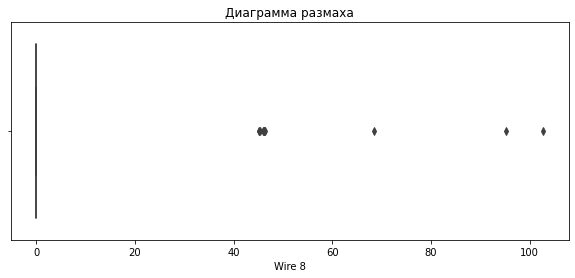

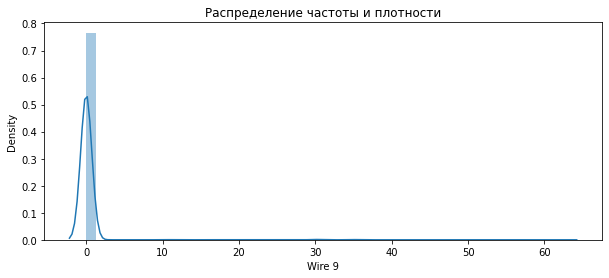

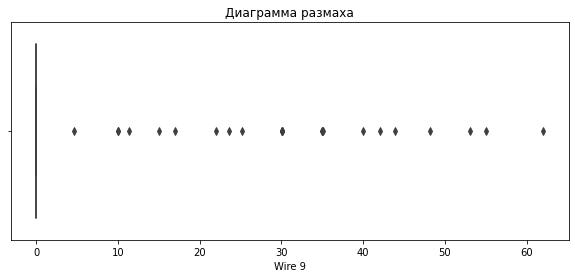

In [ ]:
for column in general_data.columns:
    if column[0] != 'W':
        continue
    draw_charts(column)

Также посмотрим и на показатель времени применения данных материалов.

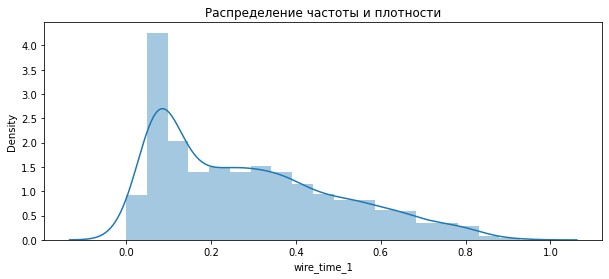

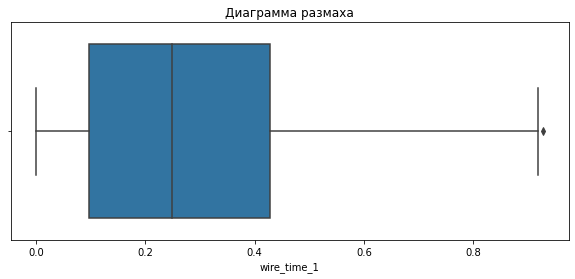

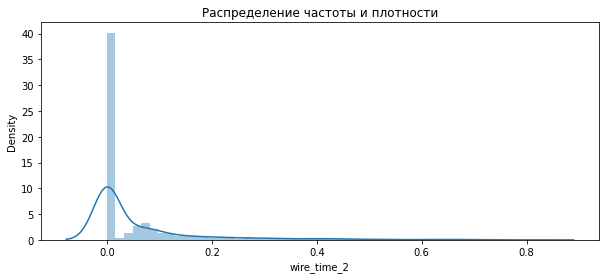

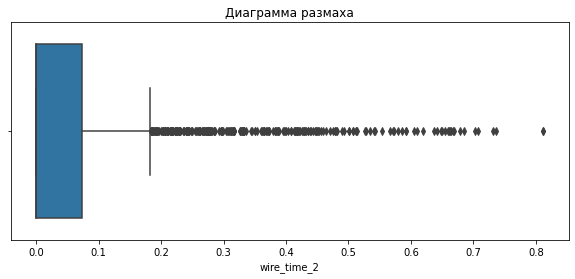

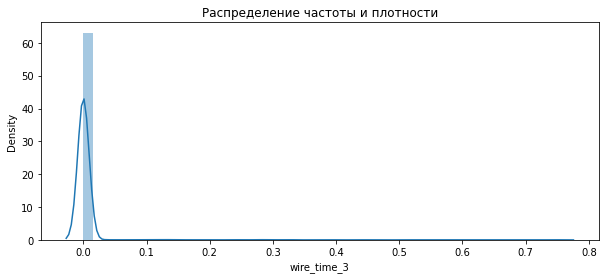

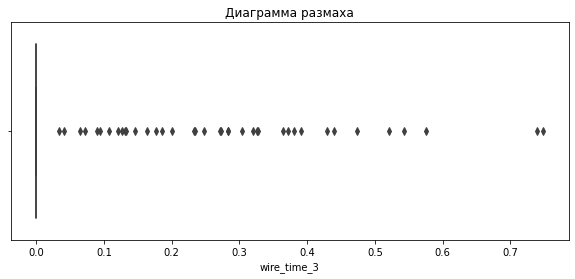

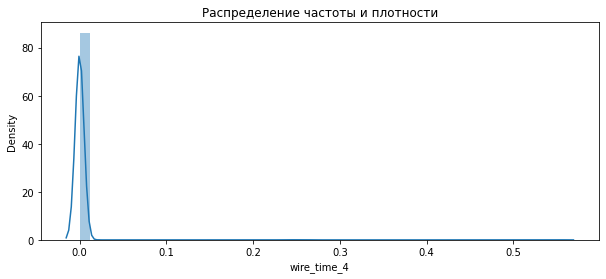

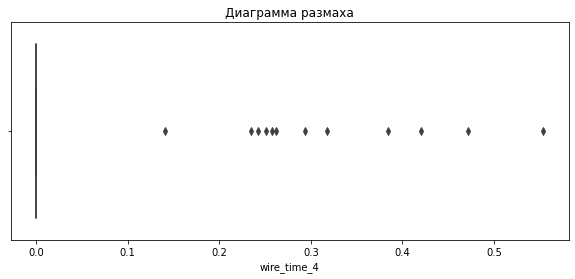

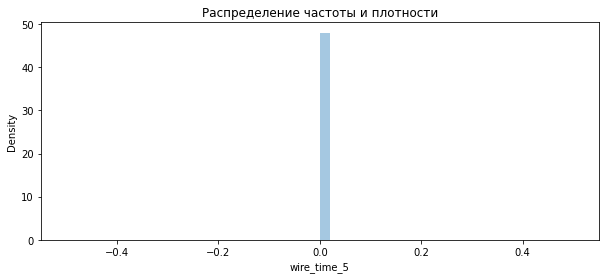

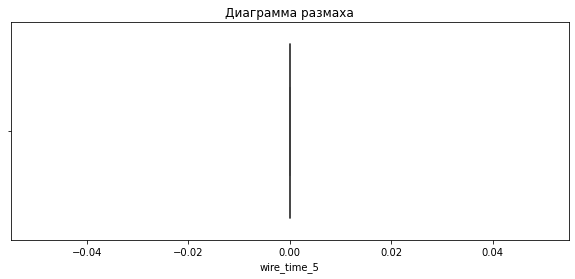

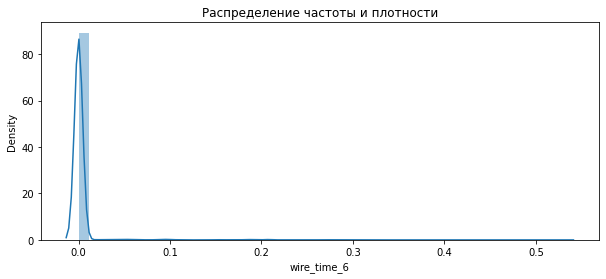

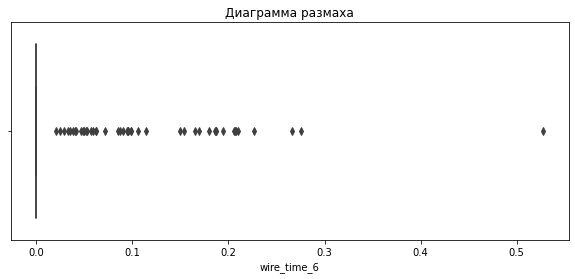

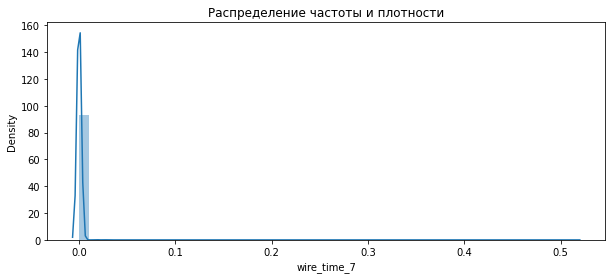

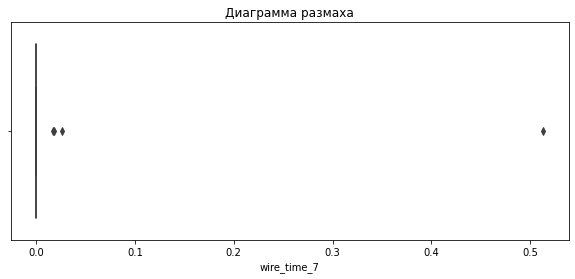

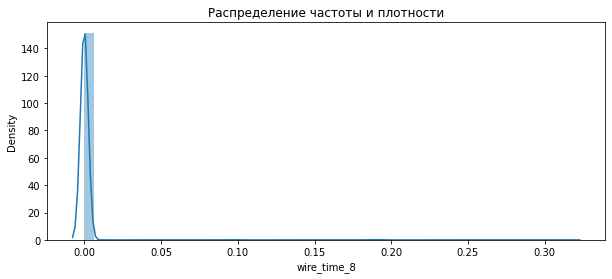

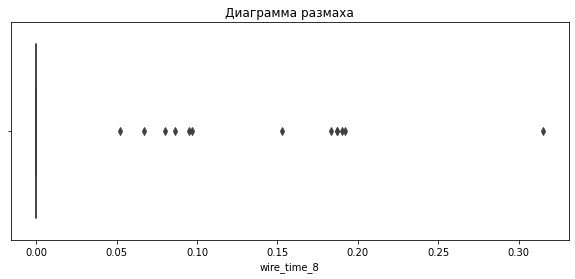

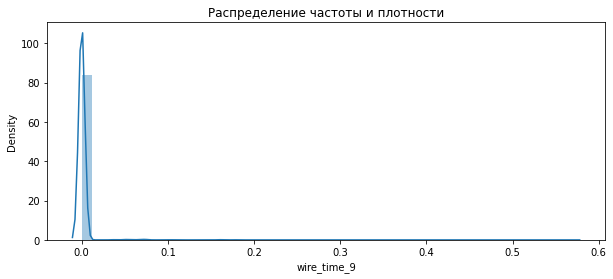

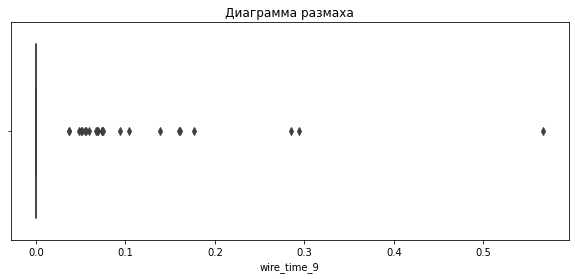

In [ ]:
for column in general_data.columns:
    if column[0] != 'w':
        continue
    draw_charts(column)

Как мы видим, существенное значение, и тут вероятно будут иметь признаки подачи проволочных материалов (как по объему так и по времени, так как они в целом имеют сходное значеие по причине их существенной корреляции друг с другом) под номерами 1 и 2, которые смещены влево ввиду их использования не всегда и соответствено наличия в этих признаков условных показателей *0*. В то же время остальные признаки применялись очень нечасто, вследствие графики показывают основное нахожение их значений в районе *0*. Данные по материалам под номером 5 вообще отсутствуют. По всей видимости, такие признаки можно было бы и удалить из обучающей выборки как выбросы, но в то же время мы не знаем, как в действительности они могли бы влиять на целевой показатель, в связи с чем имеется желание пока их оставить и вернуться к данному вопросу лишь в случае, если задача не будет решаться.

Изучив данные распределения частот, плотности и диаграммы размаха всех признаков, наибольший интерес (помимо целевого признака последней температуры) представлят данные о первой температуре, затратах мощности, общем времени работы с партией и времени нарева, подаче газ, а также некотоые признаки о подаче материалов.

**Вывод по этапу:**

Нами была подготовлена таблица с интересующими данными для обучения моделей. Одна состоит из 2329 случаев (партий) и 54 признаков (после удаления ненужных столбцов).

### Обучение моделей.

Предварителньно импортируем еще ряд бибилиотек, которые должны нам пригодится в последующей работе.

In [ ]:
!pip install optuna -q
!pip install shap -q

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import optuna
from sklearn.dummy import DummyRegressor
import shap
from catboost import Pool

Теперь введем условие, что random_state = 140823 (согласно условиям заказчика), разделим данные на признаки и целевой признак, после чего разделим также на обучающую и тестовую выборки в соотншении 3:1, также примем количество блоков для кросс-валидации равным *5*.

In [ ]:
RANDOM_STATE = 140823

features = general_data.drop('last_temp', axis=1)
target = general_data['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features,
                                                            target,
                                                            test_size=0.25,
                                                            random_state=RANDOM_STATE)
CV_COUNTS = 5

После разделения выборки на обучающую и тестовую, давайте взглянем на признаки обучающей выборки на предмет наличия мультиколлинеарности.

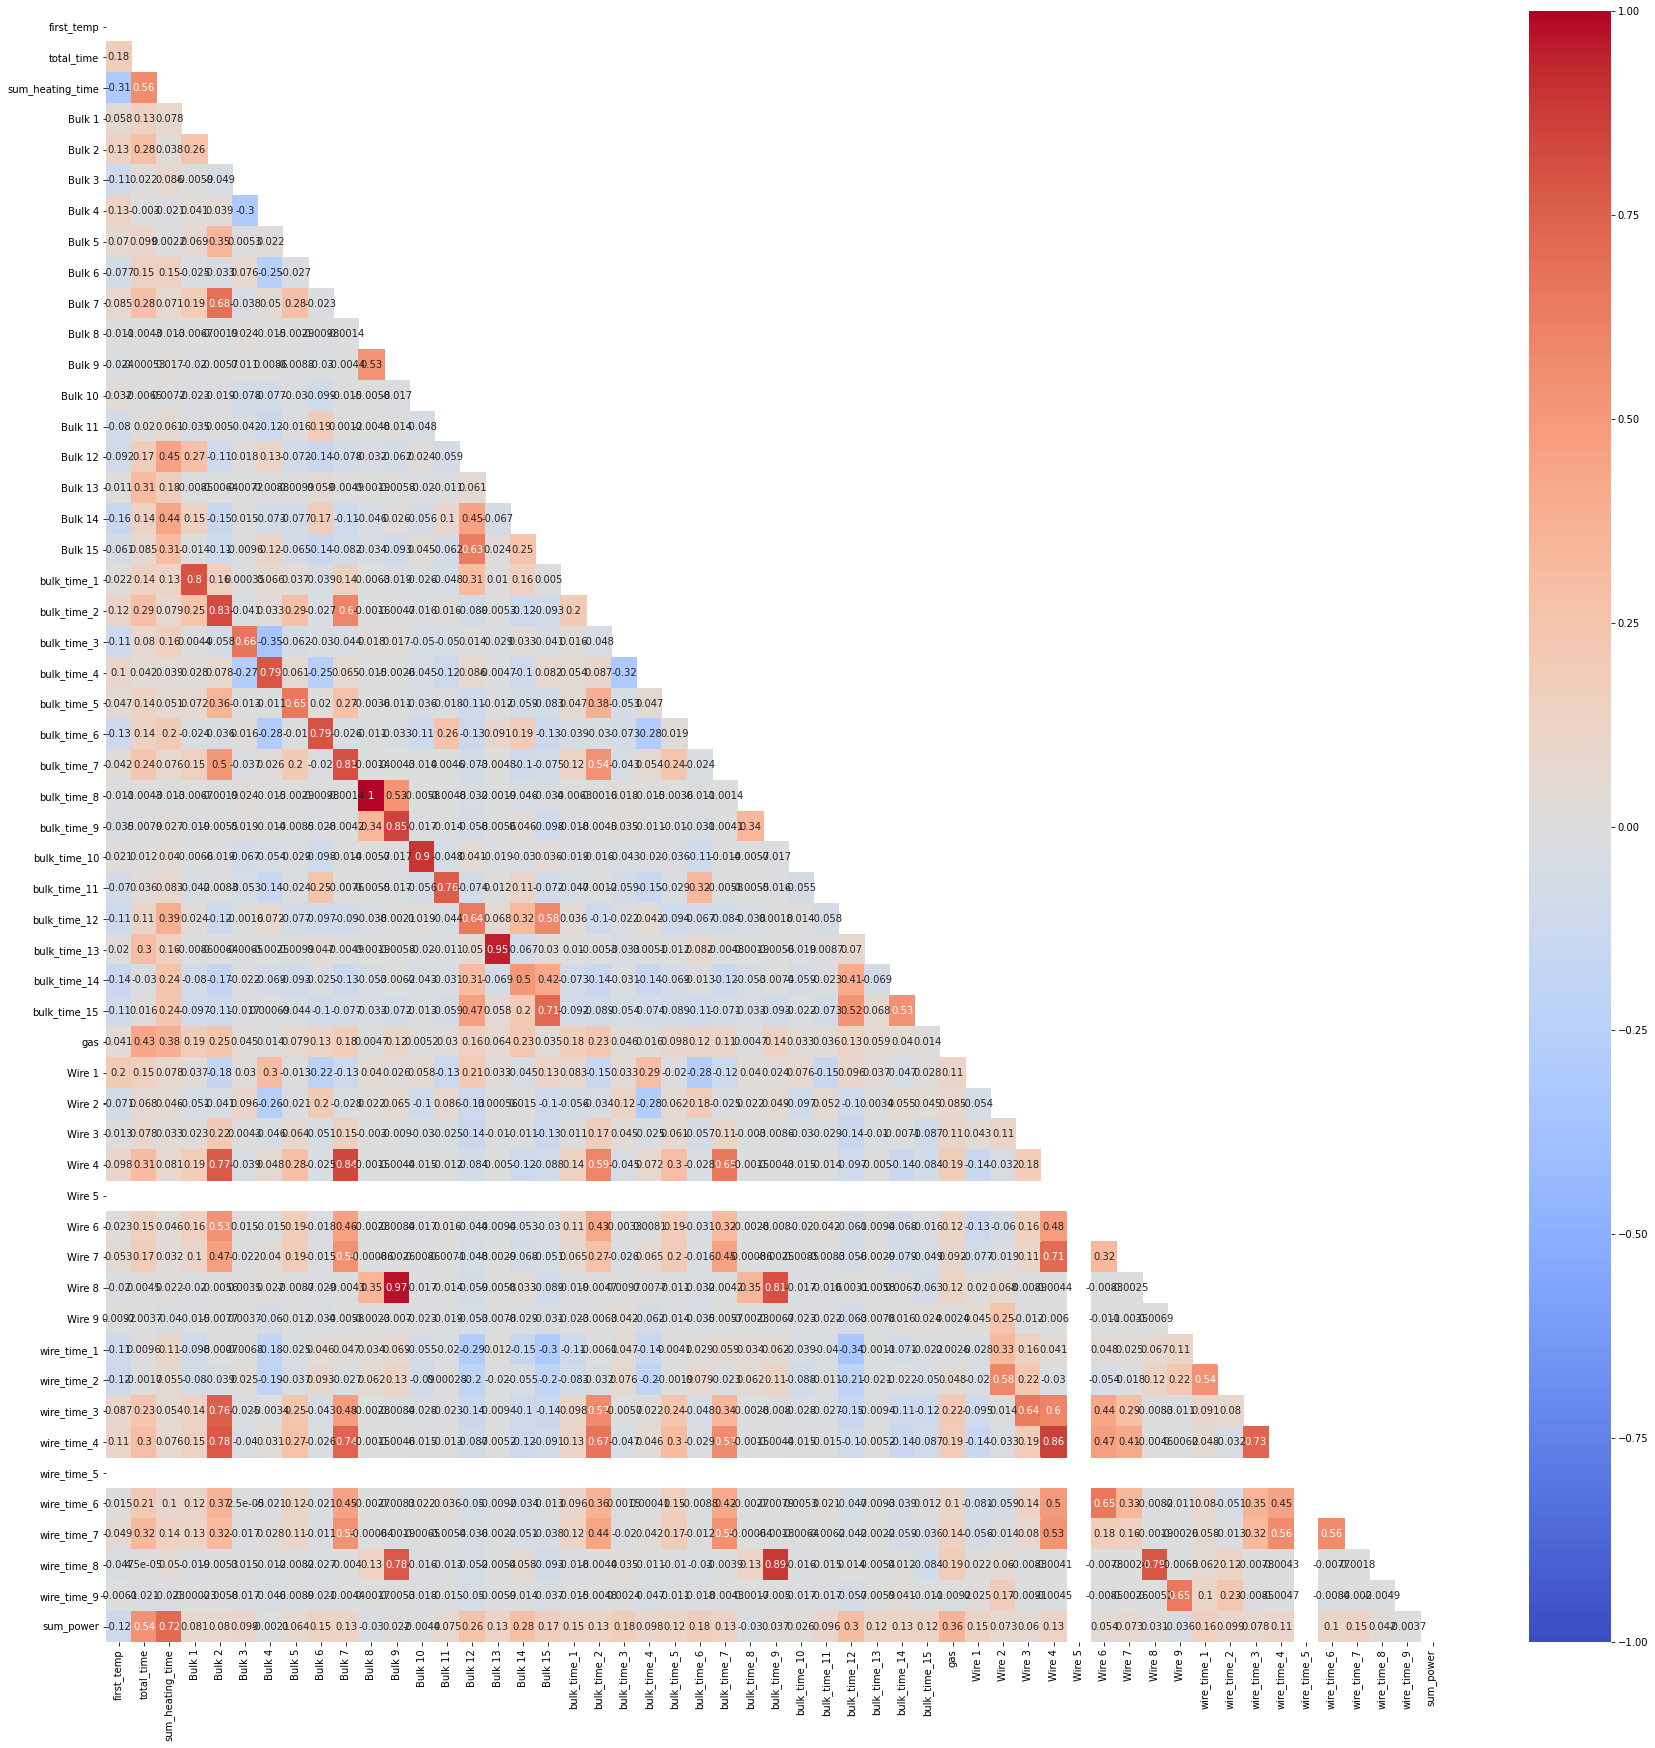

In [ ]:
upp_mat = np.triu(features_train.corr())
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(features_train.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat);

Мы видим, что по признакам **Wire 5** и **wire_time_5** какие-либо данные отсутствуют, также имеются высокие признаки линейной зависимости в ряде показателей, в частности признаки `'Bulk'` и `'bulk_time'` соответствующих номеров находятся в большой прямой линейной зависимости, что может привести к мультиколлинеарности и, зачастую, требует решения данного вопроса. Для начала попробуем посмотреть результаты обучения моделей на этих данных (в случае недостижения требуемого результата примем решение по данному вопросу).

Теперь приступим к обучению различных моделей и их оценке по лучшим параметрам на кроссвалидации. Уочяем, что целью является достижение моделью метрики МАЕ менее 6.8, в то же время в качестве самостоятельной индивидуальной цели себе поставлена задача попытаться достигнуть метрики МАЕ менее 6.

#### Линейная регрессия.

Обучим модель линейной регрессии.

In [ ]:
%%time

regressor = LinearRegression()
print('# Обучение и проверка на кросс-валидации')
print()
cv_MAE_LR = (cross_val_score(regressor,
                             features_train,
                             target_train,
                             cv=CV_COUNTS,
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Среднее MAE на кросс-валидации =', cv_MAE_LR)

# Обучение и проверка на кросс-валидации

Среднее MAE на кросс-валидации = 6.604472244682114
CPU times: user 413 ms, sys: 830 ms, total: 1.24 s
Wall time: 1.26 s


Результат не плохой **6.6**, в принципе с поставленной задачей справляется.

#### Случайный лес.

Обучим модель случайного леса.

In [ ]:
%%time

regressor = RandomForestRegressor()
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(800, 1201, 50)],
                'random_state':[RANDOM_STATE]}]

print('# Обучение и подбор оптимальных гиперпараметров по метрике MAE')
print()
clf = GridSearchCV(estimator=regressor, param_grid=hyperparams, scoring='neg_mean_absolute_error', cv=CV_COUNTS)
clf.fit(features_train, target_train)
print("Лучший найденный набор гиперпараметров:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Обучение и подбор оптимальных гиперпараметров по метрике MAE

Лучший найденный набор гиперпараметров:

{'criterion': 'mse', 'n_estimators': 1100, 'random_state': 140823}

Сетка оценок:

6.168777 for {'criterion': 'mse', 'n_estimators': 800, 'random_state': 140823}
6.169034 for {'criterion': 'mse', 'n_estimators': 850, 'random_state': 140823}
6.166692 for {'criterion': 'mse', 'n_estimators': 900, 'random_state': 140823}
6.162747 for {'criterion': 'mse', 'n_estimators': 950, 'random_state': 140823}
6.160197 for {'criterion': 'mse', 'n_estimators': 1000, 'random_state': 140823}
6.158155 for {'criterion': 'mse', 'n_estimators': 1050, 'random_state': 140823}
6.157487 for {'criterion': 'mse', 'n_estimators': 1100, 'random_state': 140823}
6.158750 for {'criterion': 'mse', 'n_estimators': 1150, 'random_state': 140823}
6.157909 for {'criterion': 'mse', 'n_estimators': 1200, 'random_state': 140823}

CPU times: user 10min 57s, sys: 1.33 s, total: 10min 58s
Wall time: 11min 1s


Мы получаем приемлемый результат, даже более лучший, чем предыдущая модель.

#### Регрессия опорных векторов.

Обучим модель опорных векторов.

In [ ]:
%%time

regressor = SVR()

hyperparams = [{'C':[x for x in range(1200, 1701, 50)],
                'epsilon':[1/x for x in range(50, 101, 25)]}]

print('# Обучение и подбор оптимальных гиперпараметров по метрике MAE')
print()
clf = GridSearchCV(estimator=regressor, param_grid=hyperparams, scoring='neg_mean_absolute_error', cv=CV_COUNTS)
clf.fit(features_train, target_train)
print("Лучший найденный набор гиперпараметров:")
print()
best_params_CVR = clf.best_params_
print(clf.best_params_)
print()
print("Сетка оценок:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_CVR = (max(means)*-1)

# Обучение и подбор оптимальных гиперпараметров по метрике MAE

Лучший найденный набор гиперпараметров:

{'C': 1600, 'epsilon': 0.013333333333333334}

Сетка оценок:

5.997814 for {'C': 1200, 'epsilon': 0.02}
5.997068 for {'C': 1200, 'epsilon': 0.013333333333333334}
5.996762 for {'C': 1200, 'epsilon': 0.01}
5.997580 for {'C': 1250, 'epsilon': 0.02}
5.997176 for {'C': 1250, 'epsilon': 0.013333333333333334}
5.997010 for {'C': 1250, 'epsilon': 0.01}
5.998586 for {'C': 1300, 'epsilon': 0.02}
5.998394 for {'C': 1300, 'epsilon': 0.013333333333333334}
5.998116 for {'C': 1300, 'epsilon': 0.01}
5.999011 for {'C': 1350, 'epsilon': 0.02}
5.999063 for {'C': 1350, 'epsilon': 0.013333333333333334}
5.998813 for {'C': 1350, 'epsilon': 0.01}
5.998023 for {'C': 1400, 'epsilon': 0.02}
5.997838 for {'C': 1400, 'epsilon': 0.013333333333333334}
5.997706 for {'C': 1400, 'epsilon': 0.01}
5.996718 for {'C': 1450, 'epsilon': 0.02}
5.996629 for {'C': 1450, 'epsilon': 0.013333333333333334}
5.996745 for {'C': 1450,

Неплохой результат, метрика МАЕ даже чуть ниже 6.

####  CatBoostRegressor.

Обучим модель CatBoostRegressor.

Для начала используем **optuna** и попробуем подобрать 3 оптимальных для решения гиперпараметра модели CatBoostRegressor (мною были выбраны learning_rate, depth и l2_leaf_reg).

In [ ]:
%%time

def objective(trial):

    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1),
    "depth": trial.suggest_int("depth", 2, 12),
    "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 9)
    }

    model = CatBoostRegressor(**param, loss_function='MAE', verbose=False, random_seed=RANDOM_STATE)

    model.fit(features_train, target_train)

    preds = model.predict(features_train)
    score = mean_absolute_error(preds, target_train)
    return score

print('# Подбор оптимальных гиперпараметров по метрике MAE')
print()
seed=RANDOM_STATE
#study = optuna.create_study()
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=5)

print("Лучший найденный набор гиперпараметров:")
print()
print(study.best_params)


[I 2023-08-23 11:48:04,869] A new study created in memory with name: no-name-f7984030-6b79-4434-bb23-fa17797e85d7


# Подбор оптимальных гиперпараметров по метрике MAE



[I 2023-08-23 11:48:08,548] Trial 0 finished with value: 3.59110199207981 and parameters: {'learning_rate': 0.05558899388446194, 'depth': 4, 'l2_leaf_reg': 7}. Best is trial 0 with value: 3.59110199207981.
[I 2023-08-23 11:48:15,882] Trial 1 finished with value: 2.5507948477519844 and parameters: {'learning_rate': 0.05035154599646706, 'depth': 6, 'l2_leaf_reg': 3}. Best is trial 0 with value: 3.59110199207981.
[I 2023-08-23 11:48:27,164] Trial 2 finished with value: 1.8269876605023228 and parameters: {'learning_rate': 0.05861231906029228, 'depth': 7, 'l2_leaf_reg': 8}. Best is trial 0 with value: 3.59110199207981.
[I 2023-08-23 11:48:31,898] Trial 3 finished with value: 2.6588290049354444 and parameters: {'learning_rate': 0.09392652290138863, 'depth': 5, 'l2_leaf_reg': 7}. Best is trial 0 with value: 3.59110199207981.
[I 2023-08-23 11:49:11,011] Trial 4 finished with value: 0.6524682349167127 and parameters: {'learning_rate': 0.07597984188974889, 'depth': 9, 'l2_leaf_reg': 4}. Best is 

Лучший найденный набор гиперпараметров:

{'learning_rate': 0.05558899388446194, 'depth': 4, 'l2_leaf_reg': 7}
CPU times: user 59.5 s, sys: 737 ms, total: 1min
Wall time: 1min 6s


Теперь полученные 3 гиперпараметра используем при обучении и проверке на кроссвалидации модели CatBoostRegressor.

In [ ]:
%%time

regressor = CatBoostRegressor(loss_function='MAE', learning_rate=0.05558899388446194, depth=4, l2_leaf_reg=7, verbose=False, random_state=RANDOM_STATE)
print('# Обучение и проверка на кросс-валидации')
print()
cv_MAE_CBR = (cross_val_score(regressor,
                             features_train,
                             target_train,
                             cv=CV_COUNTS,
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Среднее MAE на кросс-валидации =', cv_MAE_CBR)

# Обучение и проверка на кросс-валидации

Среднее MAE на кросс-валидации = 5.927100139061383
CPU times: user 11.5 s, sys: 625 ms, total: 12.1 s
Wall time: 16.7 s


Теперь сохраним все параметры модели CatBoostRegressor для возможной тестовой проверки.

In [ ]:
best_params_CBR = CatBoostRegressor(loss_function='MAE', learning_rate=0.05558899388446194, depth=4, l2_leaf_reg=7, verbose=False, random_state=RANDOM_STATE).fit(features_train, target_train).get_all_params()
best_params_CBR

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Exact',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 7,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 140823,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MAE',
 'learning_rate': 0.055588994175195694,
 'score_function': 'Cosine',
 'task_ty

Результат довольно неплох, существенно лучше предыдущих моделей. Кроме того, мы достиги показателя метрики МАЕ менее 6.

**Выводы по этапу:**

Иак, модель CatBoostRegressor достигла показателя метрики MAE менее 6, что для нас является удовлетворительным результатом. Данная модель показала лучший результат, ее и будем тестировать на следующем этапе.

### Тестирование лучшей модели.

Теперь проведем проверку метрики МАЕ на тестовой выборке с лучшей моделью, полученной на предыдущем этапе, которой дадим лучшие параметры.

In [ ]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(target_predict, target_test)
print('Показатель метрики МАЕ на тестовой выборке модели CatBoostRegressor =', test_MAE_CBR)

Показатель метрики МАЕ на тестовой выборке модели CatBoostRegressor = 6.012760739626055
CPU times: user 2.48 s, sys: 116 ms, total: 2.6 s
Wall time: 3.64 s


На тестовой выборке модель CatBoostRegressor также показала метрику МАЕ 6.012760739626055. Результат достигнут. Теперь предлагаю сравнить данный показатель с показателем простой модели DummyRegressor, которая просто предсказывает среднее значение температуры.

In [ ]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(features_train, target_train)
target_predict = model_dummy.predict(features_test)
test_MAE_dummy = mean_absolute_error(target_predict, target_test)
print('MAE на проверочной модели по среднему значению =', test_MAE_dummy)

MAE на проверочной модели по среднему значению = 8.127318703471213


Показатель MAE нашей модели CatBoostRegressor существенно лучше показателя проверочной модели, следователньо наша модель адекватна.

Теперь взглянем на то, насколько были важны некоторые признаки для достижения правильного результата.

In [ ]:
general_data.corr()['last_temp']

first_temp          0.252443
last_temp           1.000000
total_time          0.096505
sum_heating_time    0.278716
Bulk 1             -0.075206
Bulk 2             -0.082454
Bulk 3             -0.035977
Bulk 4              0.187970
Bulk 5             -0.028355
Bulk 6             -0.181816
Bulk 7             -0.107275
Bulk 8             -0.026587
Bulk 9             -0.016075
Bulk 10             0.061350
Bulk 11            -0.114753
Bulk 12             0.267424
Bulk 13            -0.010920
Bulk 14             0.114617
Bulk 15             0.266414
bulk_time_1        -0.004942
bulk_time_2        -0.043011
bulk_time_3        -0.001247
bulk_time_4         0.209912
bulk_time_5        -0.061193
bulk_time_6        -0.199692
bulk_time_7        -0.152505
bulk_time_8        -0.026587
bulk_time_9        -0.011152
bulk_time_10        0.064730
bulk_time_11       -0.097323
bulk_time_12        0.217446
bulk_time_13       -0.010886
bulk_time_14        0.077690
bulk_time_15        0.159436
gas           

Таким образом, мы видим, что для линейных моделей довольно важны показатели первоначальной температуры, мощности, суммарного времени нагрева, а также ряд показателей, касающихся подачи материалов (используемых обычно наиболее часто). Другие признаки оказывают меньшее влияние.

Что касается нелинейных моделей, то тут несколько сложнее. Для анализа того, как оценивать вклад каждого признака для обучения модели CatBoostRegressor можно воспользоваться библиотекой shap.

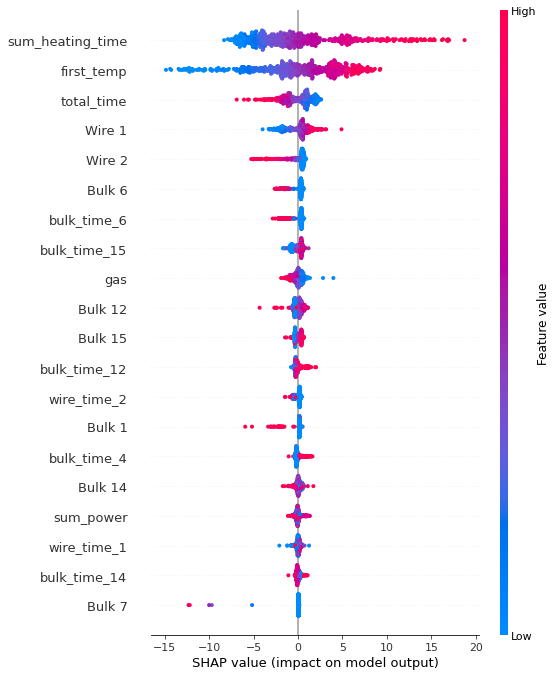

In [ ]:
shap_values = model.get_feature_importance(Pool(features_test, label=target_test), type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.summary_plot(shap_values, features_test, auto_size_plot=True)

Как мы видим на графике, наибольшее значение для прогноза модели сыграли признаки времени нагрева, первой замеренной температуры, общего времени работы, а также испольование различных материалов (Wire 1, Wire 2, Bulk 6).

**Выводы по этапу:**

Модель CatBoostRegressor показала значение МАЕ около 6 на тестовой выборке и достигла требуемого результата.

**Общий вывод:**



Нами была получена рабочая модель машинного обучения CatBoostRegressor, которой по метрике МАЕ на тестовой выборке удалось достигнуть результата 6.012760739626055. Задача выполнена.